## 1. Preparacao do Ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # exibir todas as colunas do dataframe na tela

In [3]:
rcParams['figure.figsize'] = 15, 4

In [4]:
seed = 0 # seed para geracao de numeros aleatorios

In [5]:
def count_nans(col, df):
    """
    Dada uma coluna col de um pandas.DataFrame df, imprime um texto com a quantidade absoluta e relativa (%) de numpy.nan
    """
    
    nans = df[col].isna().sum()
    
    count = df.shape[0]
    
    print(f' Total de NaNs na coluna {col}: {nans} entre {count} ({round(nans/count, 4)*100}%)')

In [6]:
def numeric_to_log(col, df, eps = 0.001, nan_value = np.nan, drop_original_feature = True):
    """
    Dada uma coluna numerica col de um pandas.DataFrame df, cria uma nova coluna com o np.log de seu valor.
    Caso o valor da coluna seja menor que eps, retornar o valor nan_value.
    Caso drop_original_features seja True, deleta a coluna col do dataframe.
    """
    
    df[f'log_{col}'] = df[col].apply(
        lambda x: np.log(x) if x > eps else nan_value
        )
    
    if drop_original_feature:
        df.drop(columns = col, inplace = True)

In [7]:
def string_to_category(col, df, nan_as_category = True):
    """
    Dada uma coluna string col de um pandas.DataFrame df, converte-a para tipo categorico.
    Caso nan_as_category seja True, np.nan serao considerados tambem como uma categoria.
    """
    
    if nan_as_category:
        df[col] = df[col].fillna('NaN') # Substituindo NaNs por String para garantir que sejam tratados como uma categoria a parte
    
    df[col] = df[col].astype('category')

In [8]:
def string_to_numeric(col, df, char_list = ['$', '%'], remove_comma = True):
    """
    Dada uma coluna string col de um panads.DataFrame df, converte-a em coluna numerica.
    char_list e uma lista de strings que serao removidos (pd.str.strip) do string antes da conversao.
    se remove_comma for True, virgulas serao substituidas por espacos vazio.
    """
    
    for char in char_list:
        df[col] = df[col].str.strip(char)
    
    if remove_comma:
        df[col] = df[col].str.replace(',', '')
    
    df[col] = pd.to_numeric(df[col], errors = 'coerce')    

In [9]:
def date_to_numeric(col, df, ref_date = '2010-01-01'):
    """
    Dada uma coluna string col de um panda.DataFrame df contendo uma data no formato 'YYYY-MM-DD' de um pandas.DataFrame, converte-a
    em um numero que representa a quantidade de dias entre a data e uma data de referencia ref_date.
    """
    
    df[col] = (pd.to_datetime(df[col]) - pd.to_datetime(ref_date)).dt.days

In [10]:
def replace_infinity(col, df, absurd_threshold = 1e4):
    """
    Dada uma coluna numerica col de um panda.DataFrame df, substitui todos os valores que ultrapassarem
    o limite absurd_threshold pelo valor maximo das linhas que nao ultrapassam esse limite.
    """
    
    absurd_mask =  (df[col] > 1e4)
    non_absurd_max = df.loc[~absurd_mask, col].max() # valor maximo das outras colunas. Sera adotado como novo valor apra as colunas com valores absurdos.
    df.loc[absurd_mask, col] = non_absurd_max
    
    print(f'Encontradas {absurd_mask.sum()} entradas superiores a {absurd_threshold} na coluna {col}. Esses valores foram susbtituidos por {non_absurd_max}')

In [11]:
def plot_categories_count(col, df, max_number_cat = None, violin_col = None,):
    """
    Dada uma coluna categoria col de um pandas.DataFrame df, plota um grafico de barras com a contagem de ocorrência de cada categoria no dataset.
    Caso definido max_number_cat, apenas as max_number_cat categorias mais populosas sao mostradas.
    Caso definido violin_col, plota-se um gráfico seaborn.violinplot com a coluna violin_col no eixo x, segmetnada categoricamente pela coluna col
    """
    
    order = df[col].value_counts().index[:max_number_cat]
    
    sns.countplot(x = col, data = df, order = order)
    plt.show()
    
    if violin_col:
        sns.violinplot(x = col, y = violin_col, data = df, order = order)
        plt.show()

In [12]:
def one_hot_encode(col, df, max_number_cat = None, leave_one_out = True, drop_original_feature = True):
    """
    Dada uma coluna categorica col de um pandas.DataFrame df, cria-se novas colunas binaras para cada categoria (one hot encoding)
    Se leave_one_out for True, uma das categorias nao sera considerada para evitar colinearidade.
    Se for fornecido um numero para max_number_cat, apenas as max_number_cat categorias mais populosas serao consideradas. Nesse caso, leave_one_out sera considerado false
    Se drop_original_feature for true, a coluna col sera removida do dataset
    """
    if max_number_cat:
        cats = df[col].value_counts().index[:max_number_cat]
        leave_one_out = False # como ja estamos limitando numero de categorias, nao vamos tirar mais uma
    
    else:
        cats = list(df[col].unique())
    
    if leave_one_out:
        cats = cats[:-1]
    
    for cat in cats:
        df[f'{col}_is_{cat}'] = (df[col] == cat).astype('int')
    
    if drop_original_feature:
        df.drop(columns = col, inplace = True)

In [13]:
def one_hot_encode_selected_categories(col, df, selected_categories, violin_col = None, plot = True, drop_original_feature = True):
    """
    TODO
    """
    for cat in selected_categories:
        new_col = f'{col}_has_{cat}'
        df[new_col] = df[col].apply(
            lambda x: 1 if cat in str(x) else 0
            )
    
        if plot:
            print('>'*10,' '*3, cat)
            plot_categories_count(new_col, df, violin_col = violin_col)
        
    if drop_original_feature:
        df.drop(columns = col, inplace = True)

In [14]:
def get_uniques_from_list_of_lists(col, df, chars_to_replace = ['"'], chars_to_strip = ['[', ']'], pat = ','):
    """
    Dada uma coluna col contendo listas de elementos em um pandas.DataFrame df.
    Retorna o set com os elementos unicos considerando todas as listas de todas as linhas.
    char_to_replace e uma lista com strings que serao substiuidas por espacoz vazios.
    chars_to_strip sao as strings que serao usadas pela funcao pd.str.strip.
    """
    
    df[col].fillna('NaN', inplace = True)
    
    # elimina chars que podem atrapalhar a extracao das categorias
    for char in chars_to_replace:
        df[col] = df[col].str.replace(char, "")
    
    # elimina chars que podem atrapalhar a extracao das categorias
    for char in chars_to_strip:
        df[col] = df[col].str.strip(char)
    
    # gera uma lista com os elements separados por pat
    df[col] = df[col].str.split(pat = pat)
    
    return set(itertools.chain.from_iterable(df[col]))

## 2. Leitura dos dados

Dataset coletado em http://insideairbnb.com/get-the-data.html no dia 27-abr-2021 as 14h20. <br>
Dados referentes a cidade de <b>Rio de Janeiro</b>, consolidados em <b>22-fev-2021</b>.

In [15]:
df = pd.read_csv('listings.csv')

## 3. Inspecao dos dados

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26615 entries, 0 to 26614
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            26615 non-null  int64  
 1   listing_url                                   26615 non-null  object 
 2   scrape_id                                     26615 non-null  int64  
 3   last_scraped                                  26615 non-null  object 
 4   name                                          26586 non-null  object 
 5   description                                   25160 non-null  object 
 6   neighborhood_overview                         14314 non-null  object 
 7   picture_url                                   26615 non-null  object 
 8   host_id                                       26615 non-null  int64  
 9   host_url                                      26615 non-null 

In [17]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\r\nI am a filmmaker and a tea...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,90,3.0,3.0,90.0,90.0,3.0,90.0,NaN,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","French girl ""lost in Brazilian translation"" si...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""Kitche

Na seção a seguir, cada coluna de dados será inspecionada.<br>
Caso seja constatada que ela não traz informações relevantes, ela será adicionada a lista de non_informative_columns e será descartada do dataset. <br>
As colunas do tipo texto serão salvas em uma lista text_columns para, em um segundo momento, originarem novas features, como, por exemplo: Análise de Sentimento do texto, número de caractéres e etc.

In [18]:
non_informative_columns = [] # Colunas que nao trazem informacoes relevantes para predicao
text_columns = [] # Colunas do tipo texto serão armazenadas e em um segundo momento algumas features como análise de sentimento, número de caractéres e outros possam ser extraidas

### 3.1. Variável resposta: PRICE

In [19]:
count_nans('price', df)

 Total de NaNs na coluna price: 0 entre 26615 (0.0%)


O preço é fornecido como uma string, com o $ no começo da cadeia. Logo, devemos remover o símbolo e conevertê-lo a formato numérico. Detalhe que 

In [20]:
string_to_numeric('price', df)

In [21]:
count_nans('price', df)

 Total de NaNs na coluna price: 0 entre 26615 (0.0%)


Todos os preços foram convertidos com sucesso para formato numérico. Agora, avalia-se a distribuição dos preços para identificação de anomalias

In [22]:
df['price'].describe()

count     26615.000000
mean        742.589254
std        5368.868834
min           0.000000
25%         157.000000
50%         280.000000
75%         550.000000
max      625216.000000
Name: price, dtype: float64

O preço máximo observado é de 625 mil reais. Valor estranho para operações de airbnb. Observa-se os maiores valores para entender se há outros pontos com essa característica.

In [23]:
corte = df['price'].mean() + 3*df['price'].std()
mask = df['price'] < corte
outliers_count = (~mask).sum()
outliers_relativo = outliers_count/mask.count()

print(f'{outliers_count} pontos ({round(outliers_relativo, 4)*100}% dos dados) apresentam preços superiores ao valor de corte de {round(corte, 2)} (média + 3*desvios).')

78 pontos (0.29% dos dados) apresentam preços superiores ao valor de corte de 16849.2 (média + 3*desvios).


Como esses valores não são factíveis. Eles serão eliminados do dataset. A distribuição resultante é mostrada a seguir.

In [24]:
df = df.loc[mask]

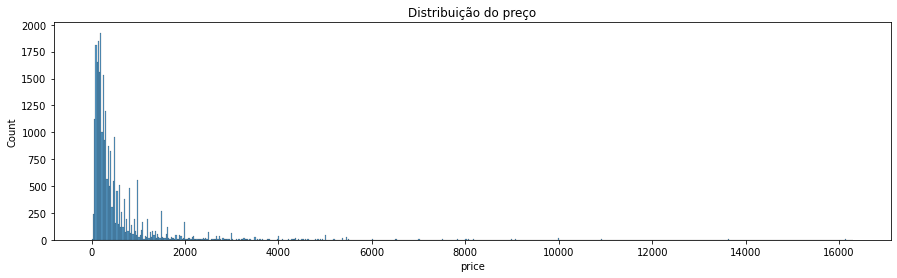

In [25]:
sns.histplot(x = 'price', data = df.loc[mask])
plt.title('Distribuição do preço')
plt.show()

A distribuição parece uma log normal. Sendo assim, plota-se a distirbuição do logaritmo do preço para inspeção.

In [26]:
numeric_to_log('price', df)

In [27]:
count_nans('log_price', df)

 Total de NaNs na coluna log_price: 7 entre 26537 (0.03%)


Existem 7 entradas com preços nulos e que resultaram em np.nan. Como preço nulo é uma situação anômala, esses pontos serão removidos do dataset.

In [28]:
mask = ~df['log_price'].isna()
df = df.loc[mask]

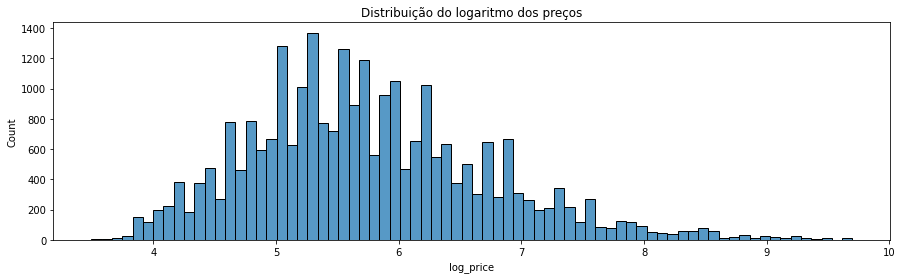

In [29]:
sns.histplot(x = 'log_price', data = df)
plt.title('Distribuição do logaritmo dos preços')
plt.show()

A distribuicao do log do preco ao inves do preco apresenta uma menor variacao de magnitude alem de apresentar uma distribuicao mais proxima a uma curva normal. Assim, ela sera preferida em relacao ao preco original para efeitos de analise exploratoria e desenvolvimento do modelo de machine learning.

### 3.2. Informações básicas do HOST e do anúncio

In [30]:
print(f'    Linhas do dataset: {df.shape[0]}\n    Número de IDs únicos {df["id"].nunique()}\n    Número de hosts únicos {df["host_id"].nunique()}')

    Linhas do dataset: 26530
    Número de IDs únicos 26530
    Número de hosts únicos 17288


Observa-se que cada linha de dados corresponde a um único anúncio do AirBnB. Contudo, um mesmo host pode ter vários anúncios. Isso é confirmado pelas variáveis abaixo que apresentam valores não nulos.<br> <blockquote>calculated_host_listings_count<br> calculated_host_listings_count_entire_homes<br> calculated_host_listings_count_private_rooms<br> calculated_host_listings_count_shared_rooms </blockquote> A checagem se essas contagens está coerente com os dados listados não será realizada neste primeiro momento.

Algumas informações do host e do anúncio não apresentam informação para predição e serão descartadas.

In [31]:
non_informative_columns.extend(
    [
        'id',
        'listing_url',
        'scrape_id',
        'last_scraped',
        'picture_url',
        'host_url',
        'host_name',
        'host_thumbnail_url',
        'host_picture_url',
        'host_id',
    ]
)

In [32]:
text_columns.extend(
    [
        'name',
        'description',
        'neighborhood_overview',
        'host_about',
    ]
)

A localização do Host é fornecida. Observa-se que existem hosts locais (residentes no Rio de Janeiro), hosts brasileiros, mas que não moram no Rio de Janeiro e hosts estrangeiros. Será que esses diferentes hosts praticam preços diferentes? 

In [33]:
df['host_location'] = df['host_location'].apply(
    lambda x: 'Local' if 'Rio de Janeiro' in str(x) else (
        'Brasil' if 'Brazil' in str(x) else 'Outros'
        )
)

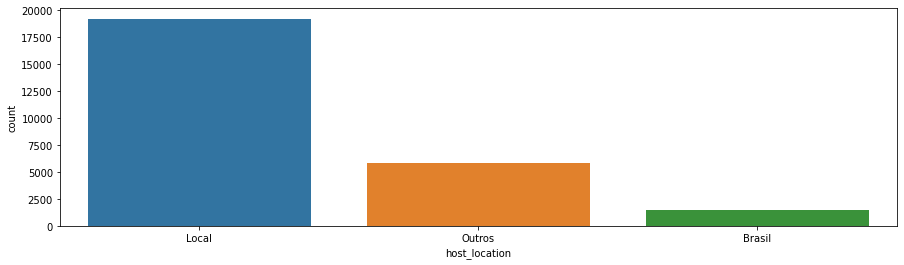

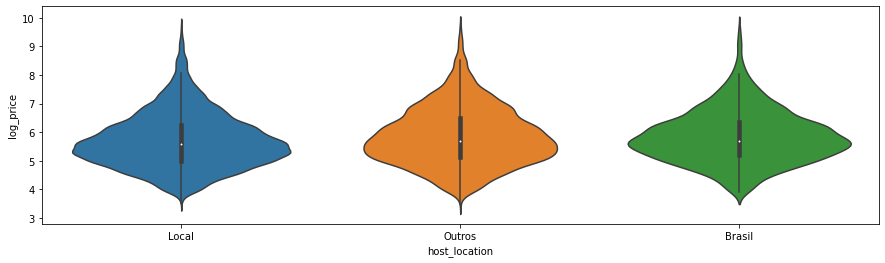

In [34]:
plot_categories_count('host_location', df, violin_col = 'log_price')

Não é observada uma diferença tão grande na distribuição de preços.

In [35]:
one_hot_encode('host_location', df)

Avaliacao da presenca ou nao de foto de perfil do host:

In [36]:
df['host_has_profile_pic'].value_counts(dropna = False)

t      26418
f         88
NaN       24
Name: host_has_profile_pic, dtype: int64

<AxesSubplot:xlabel='log_price', ylabel='Probability'>

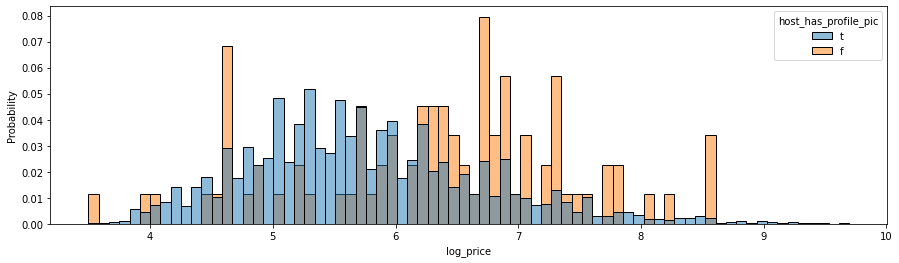

In [37]:
sns.histplot(x = 'log_price', hue = 'host_has_profile_pic', data = df, stat = 'probability', common_norm = False)

Observa-se precos relativamente maiores para os hosts sem fotos de perfil. Contudo, como eles representam pouquissimo pontos do dataset, e possivel que a diferenca seja por conta da amostra.

In [38]:
df['host_has_profile_pic'].fillna('f', inplace = True)

In [39]:
one_hot_encode('host_has_profile_pic', df)

Avaliacao da identidade verificada

In [40]:
df['host_identity_verified'].value_counts(dropna = False)

t      16701
f       9805
NaN       24
Name: host_identity_verified, dtype: int64

<AxesSubplot:xlabel='log_price', ylabel='Probability'>

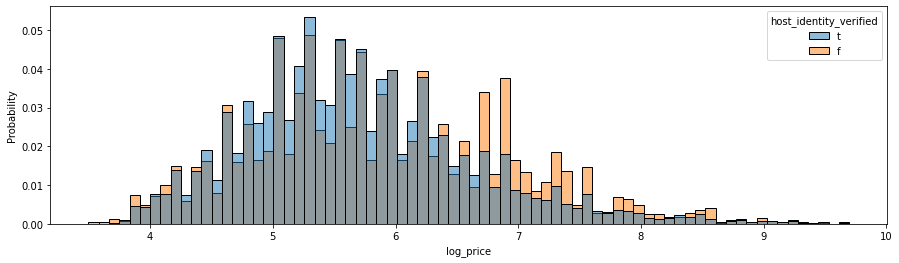

In [41]:
sns.histplot(x = 'log_price', hue = 'host_identity_verified', data = df, stat = 'probability', common_norm = False)

As duas distribuicoes parecem muito proximas. Contudo, a veriavel sera mantida no dataset e, caso de fato seja irrelevante para predicao, sera eliminada pela etapa de feature selection.

In [42]:
df['host_identity_verified'].fillna('f', inplace = True)

In [43]:
one_hot_encode('host_identity_verified', df)

Avaliacao dos tipos de verificacao do host.

In [44]:
get_uniques_from_list_of_lists('host_verifications', df)

{'',
 " 'facebook'",
 " 'google'",
 " 'government_id'",
 " 'identity_manual'",
 " 'jumio'",
 " 'kba'",
 " 'manual_offline'",
 " 'manual_online'",
 " 'offline_government_id'",
 " 'phone'",
 " 'reviews'",
 " 'selfie'",
 " 'sent_id'",
 " 'work_email'",
 "'email'",
 "'facebook'",
 "'jumio'",
 "'phone'",
 "'reviews'",
 'None'}

Como existem diversas categorias de verificacao e a verificacao de identidade se mostrou pouco relevante, essa feature sera ignorada nesse primeiro momento.

In [45]:
non_informative_columns.append('host_verifications')

Avalia-se o tempo do host

In [46]:
count_nans('host_since', df)

 Total de NaNs na coluna host_since: 24 entre 26530 (0.09%)


In [47]:
date_to_numeric('host_since', df)

<AxesSubplot:xlabel='host_since', ylabel='Count'>

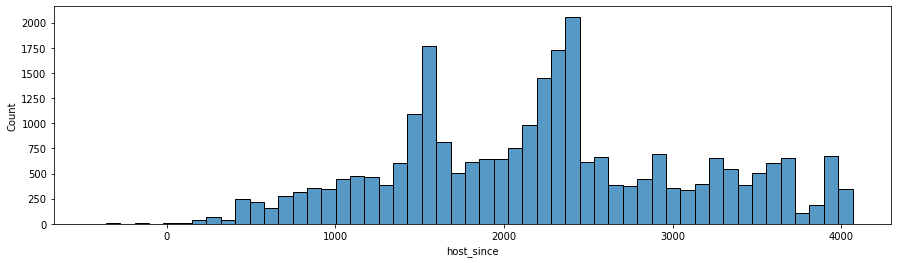

In [48]:
sns.histplot(x = 'host_since', data = df)

<AxesSubplot:xlabel='host_since', ylabel='log_price'>

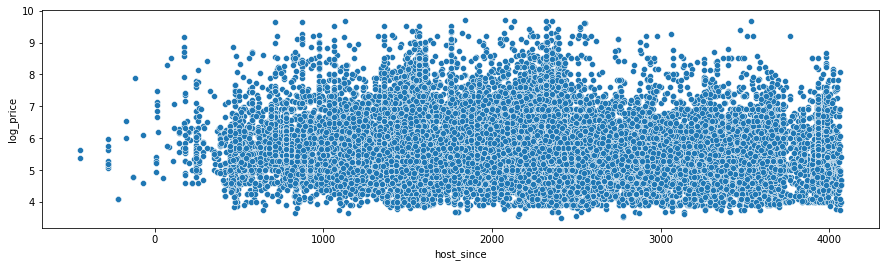

In [49]:
sns.scatterplot(x = 'host_since', y = 'log_price', data = df)

O tempo do host não parece ter relação com preco. Contudo, será usado como feature, ficando a critério do algoritmo sua utilização ou não. Para isso, completa-se os pontos ausentes com a mediana da série.

In [50]:
df['host_since'].fillna(df['host_since'].median(), inplace = True)

Contagem de anuncios do host

In [51]:
count_nans('host_listings_count', df)

 Total de NaNs na coluna host_listings_count: 24 entre 26530 (0.09%)


In [52]:
df['host_listings_count'].describe()

count    26506.000000
mean         9.299366
std         93.204871
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       7218.000000
Name: host_listings_count, dtype: float64

A grande maioria dos hosts apresenta apenas um anúncio. Contudo, tem uma grande quantidade de hosts com centenas de anúncios.

In [53]:
df['calculated_host_listings_count'].describe()

count    26530.000000
mean         9.651677
std         35.980824
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        295.000000
Name: calculated_host_listings_count, dtype: float64

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='Count'>

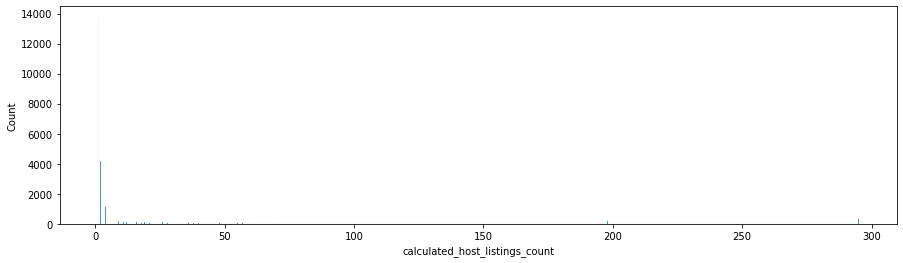

In [54]:
sns.histplot(x = 'calculated_host_listings_count', data = df)

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='log_price'>

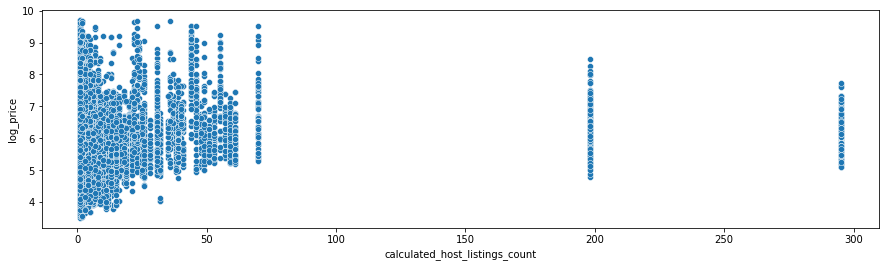

In [55]:
sns.scatterplot(x = 'calculated_host_listings_count', y = 'log_price', data = df)

In [56]:
(df['host_total_listings_count'] == df['host_listings_count']).sum()

26506

a coluna host_total_listings_count é identica a coluna host_listings count e também será eliminada

In [57]:
non_informative_columns.extend(['host_total_listings_count', 'host_listings_count'])

<AxesSubplot:xlabel='calculated_host_listings_count_entire_homes', ylabel='calculated_host_listings_count'>

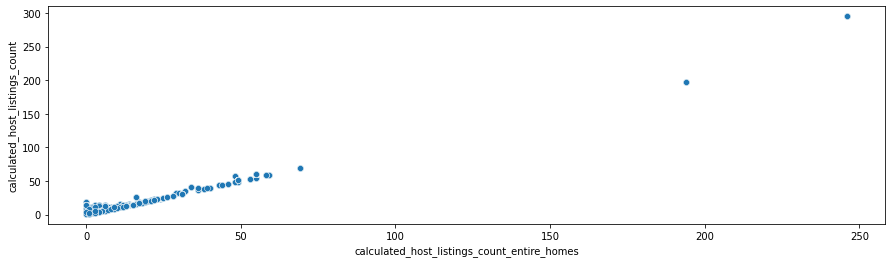

In [58]:
sns.scatterplot(x = 'calculated_host_listings_count_entire_homes', y = 'calculated_host_listings_count', data = df)

<AxesSubplot:xlabel='calculated_host_listings_count_private_rooms', ylabel='Count'>

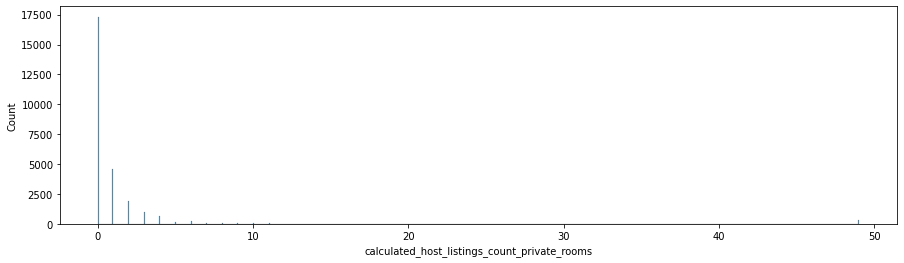

In [59]:
sns.histplot(x = 'calculated_host_listings_count_private_rooms', data = df)

<AxesSubplot:xlabel='calculated_host_listings_count_shared_rooms', ylabel='Count'>

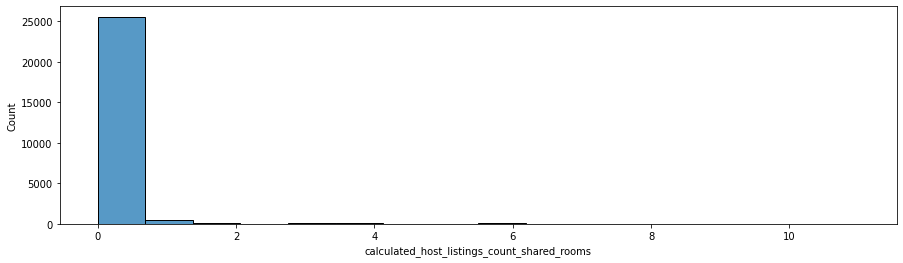

In [60]:
sns.histplot(x ='calculated_host_listings_count_shared_rooms', data = df)

In [61]:
non_informative_columns.extend([
    'calculated_host_listings_count_shared_rooms',
    'calculated_host_listings_count_entire_homes',    
])

### 3.3. Atuação do HOST - Resposta, Aceitação e Superhost

A coluna tempo de resposta é categórica. Contudo, seus valores apresentam uma hierarquia. Inspeciona-se seus valores para entender qual a prevalência de cada categoria e qual a relevãncia dos NaNs nessa feature.

In [62]:
string_to_category('host_response_time', df)

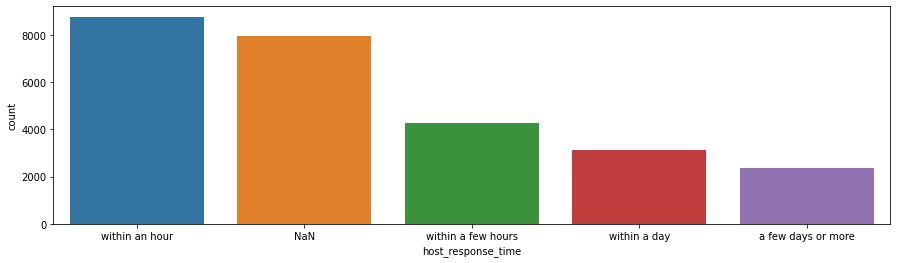

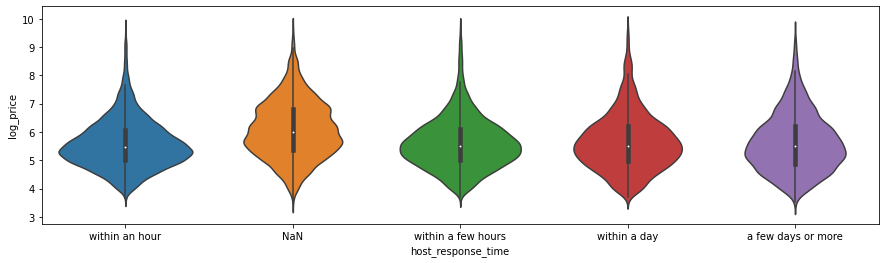

In [63]:
plot_categories_count('host_response_time', df, violin_col = 'log_price')

Não aparenta haver diferença na distribuição de preços entre as categorias de tempo de resposta do host.

In [64]:
one_hot_encode('host_response_time', df)

Taxa de resposta

In [65]:
string_to_numeric('host_response_rate', df)

<AxesSubplot:xlabel='host_response_rate', ylabel='Count'>

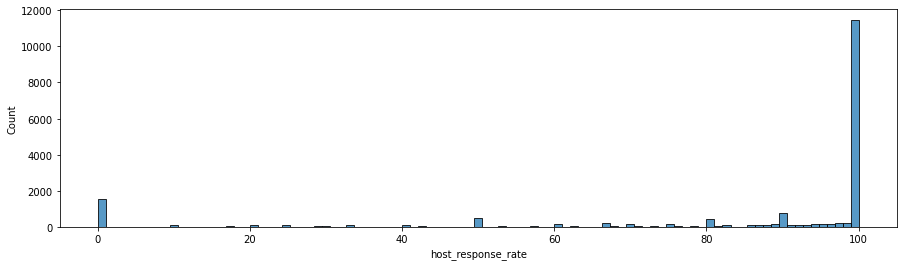

In [66]:
sns.histplot(x = 'host_response_rate', data = df)

<AxesSubplot:xlabel='host_response_rate', ylabel='log_price'>

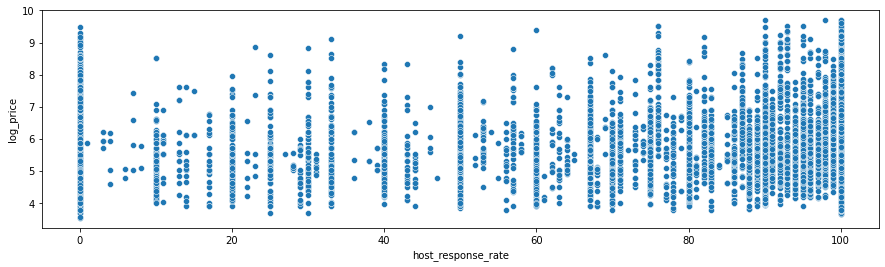

In [67]:
sns.scatterplot(x = 'host_response_rate', y = 'log_price', data = df)

In [68]:
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace = True)

A taxa de aceitação do HOST também veio formatada como string.

In [69]:
string_to_numeric('host_acceptance_rate', df)

In [70]:
df['host_acceptance_rate'].describe()

count    17032.000000
mean        75.701444
std         33.306807
min          0.000000
25%         61.000000
50%         94.000000
75%        100.000000
max        100.000000
Name: host_acceptance_rate, dtype: float64

<AxesSubplot:xlabel='host_acceptance_rate', ylabel='Count'>

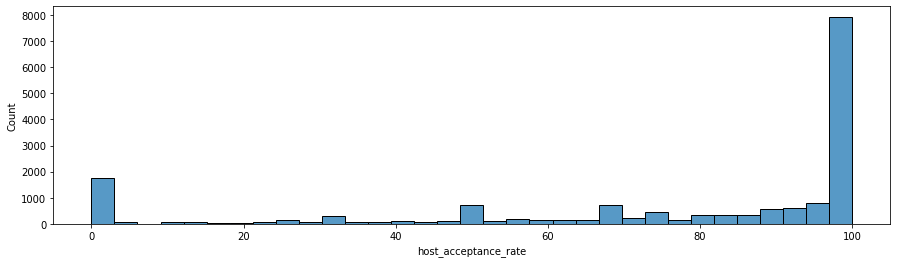

In [71]:
sns.histplot(x = 'host_acceptance_rate', data = df)

Observa-se que existe um grande número de hosts que tem uma taxa de aceite próxima a 100% e alguns próximas a 0. Não há indicios de alguma relação entre preço e taxa de aceitação.

<AxesSubplot:xlabel='host_acceptance_rate', ylabel='log_price'>

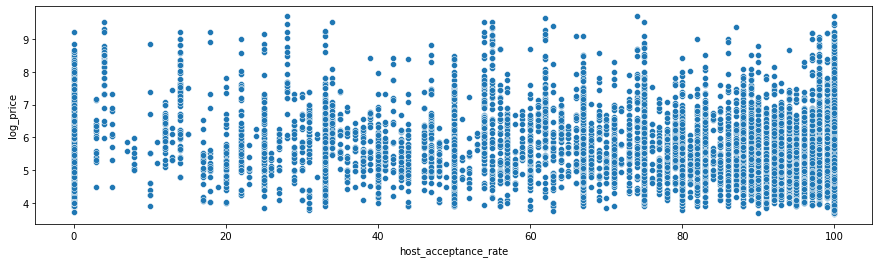

In [72]:
sns.scatterplot(x = 'host_acceptance_rate', y = 'log_price', data = df)

In [73]:
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace = True)

Não há uma relação clara entre a taxa de aceitação e preços.

In [74]:
df['host_is_superhost'].value_counts(dropna = False)

f      21969
t       4537
NaN       24
Name: host_is_superhost, dtype: int64

<AxesSubplot:xlabel='log_price', ylabel='Probability'>

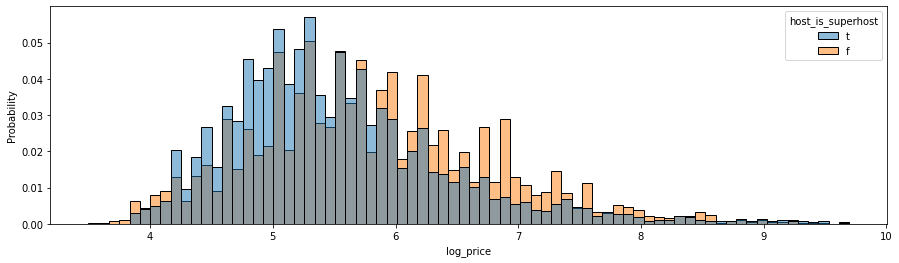

In [75]:
sns.histplot(x = 'log_price', hue = 'host_is_superhost', data = df, stat = 'probability', common_norm = False)

Também não é observada relação entre Host ser ou não superhost. Como existem poucos NaNs e a classe Falso é muito prevalente, os NaNs serão considerados False.

In [76]:
df['host_is_superhost'].fillna('f', inplace = True)

In [77]:
one_hot_encode('host_is_superhost', df)

### 3.4. Vizinhança

São observadas várias features relacionadas a vizinhança. <br>

<blockquote>
    'neighbourhood_group_cleansed' <br>
    'neighbourhood_cleansed' <br>
    'host_neighbourhood' <br>
</blockquote>
    
Explora-se elas individualmente.
    

In [78]:
count_nans('neighbourhood_group_cleansed', df)

 Total de NaNs na coluna neighbourhood_group_cleansed: 26530 entre 26530 (100.0%)


É observado que a feature 'neighbourhood_group_cleansed' não apresenta dados e portanto não é informativa.

In [79]:
non_informative_columns.append('neighbourhood_group_cleansed')

Observa-se a quantidade de anúncios por bairro classificado em 'neighbourhood_cleansed':

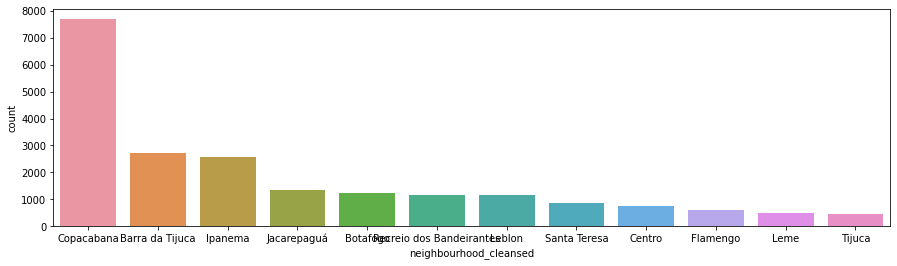

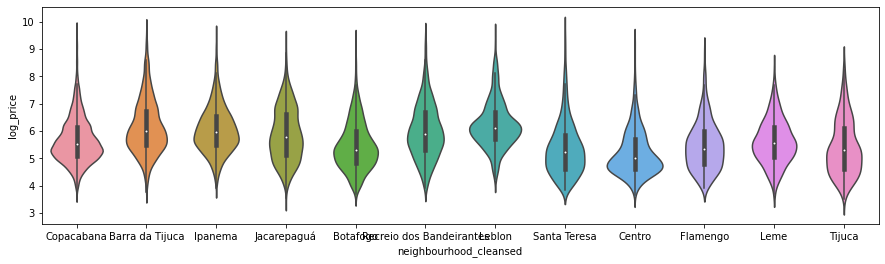

In [80]:
plot_categories_count('neighbourhood_cleansed', df, max_number_cat = 12, violin_col = 'log_price')

Observa-se que a grande maioria das localizações estão em copacabana e que os preços enter as localidades são distintos. Sendo assim, essa feature pode ser importante para o modelo preditivo. Contudo, existam mais de 150 bairros distintos nessa feature. O uso de todas essas categorias no modelo pode estar associada a um severo overfitting. Como é bservado que a partir da décima posição, a frequência de entradas passa a ser substancialmente reduzida, adota-se apenas as 10 primeiras categorias para one hot encoding. As outras serão agrupadas como 'Outros'.

Explora-se agora a feature 'host_neighbourdhood'.

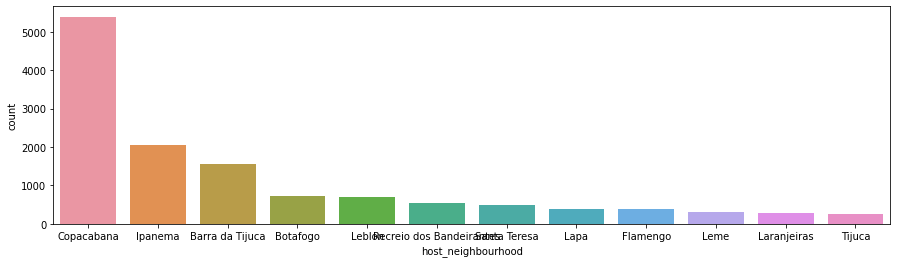

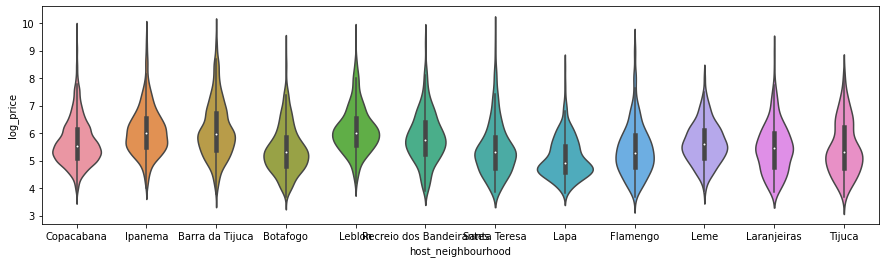

In [81]:
plot_categories_count('host_neighbourhood', df, max_number_cat = 12, violin_col = 'log_price')

 Observa-se que a contagem e as principais categorias são diferentes das vizinhancas dos anúncios. A vizinhança do host parece ter menos poder preditivo que a vizinhança do anúncio (o que faz total sentido), sendo assim manteremos apenas a vizinhança do anúncio em nossa base de dados.

In [82]:
non_informative_columns.append('host_neighbourhood')

Uma hipótese é que hosts que não moram na mesma vizinhança do anúncio possam praticar preços distintos. 

In [83]:
df['same_neighbourhood'] = df['host_neighbourhood'] == df['neighbourhood_cleansed']

In [84]:
df['same_neighbourhood'].value_counts()

False    14844
True     11686
Name: same_neighbourhood, dtype: int64

<AxesSubplot:xlabel='log_price', ylabel='Count'>

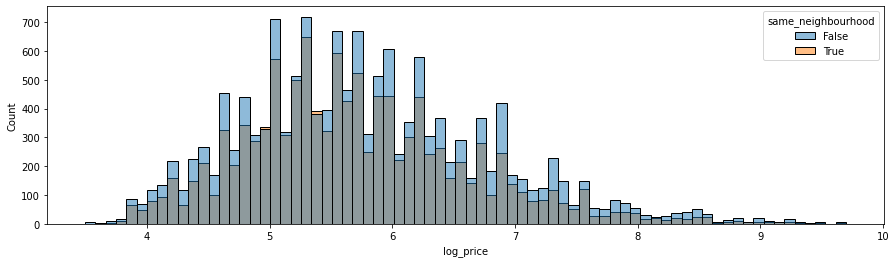

In [85]:
sns.histplot(x = 'log_price', hue = 'same_neighbourhood', data = df)

Não é observada diferença significativa entre os anúncios dos hosts que moram na mesma vizinhança de seus anúncios. Portanto essa nova feature criada será descartada.

In [86]:
non_informative_columns.append('neighbourhood')
non_informative_columns.append('same_neighbourhood')
non_informative_columns.append('host_neighbourhood')

In [87]:
one_hot_encode('neighbourhood_cleansed', df, max_number_cat = 10)

Observa-se a relação enter latitude, longitude e preço.

In [88]:
count_nans('latitude', df)
count_nans('longitude', df)

 Total de NaNs na coluna latitude: 0 entre 26530 (0.0%)
 Total de NaNs na coluna longitude: 0 entre 26530 (0.0%)


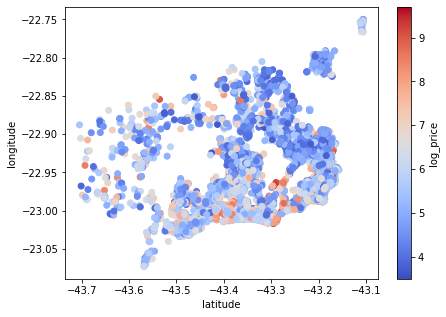

In [89]:
fig, ax = plt.subplots(figsize = (7, 5))
image = ax.scatter(x = df['longitude'], y = df['latitude'], c = df['log_price'], cmap = 'coolwarm')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(image, label = 'log_price')
plt.show()

Observa-se que alguns hotspots de preço podem ser inferidos a partir dos dados de latitude e longitude. Portanto, essas features serão mantidas no dataset.

Varias estrategias de segmentacao de localizacao poderiam ser explorados em trabalhos futuros. Poderia-se clusterizar usando latitude e longitude, trazer conhecimentos geograficos para criar features com basena localização. Poderia ser calculada a distanciaa pontos turisticos famosos e etc.

### 3.5. Características da Acomodação

property_type

In [90]:
df['property_type'].value_counts()

Entire apartment               15314
Private room in apartment       4146
Entire condominium              1260
Private room in house           1233
Entire house                    1129
                               ...  
Private room in farm stay          1
Shared room in bungalow            1
Shared room in nature lodge        1
Camper/RV                          1
Entire home/apt                    1
Name: property_type, Length: 87, dtype: int64

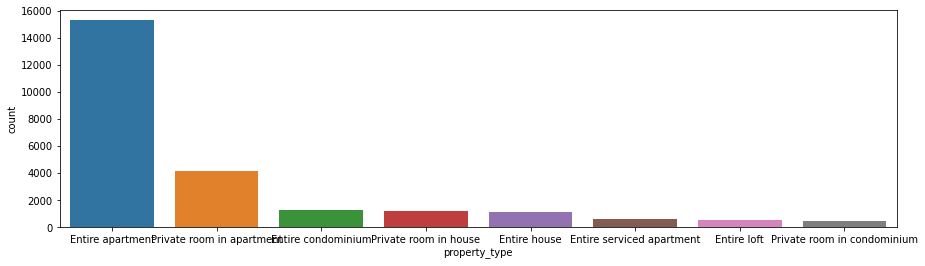

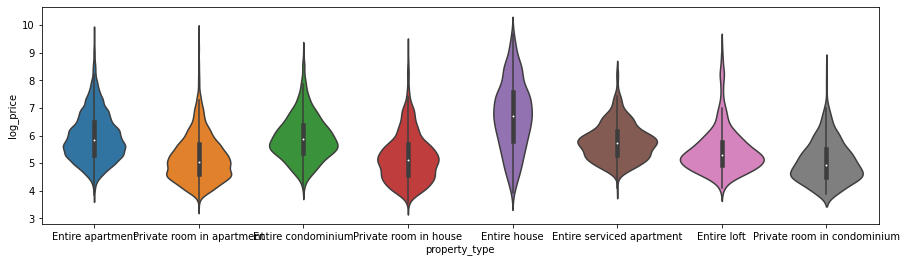

In [91]:
plot_categories_count('property_type', df, max_number_cat = 8, violin_col = 'log_price')

O tipo de propriedade não será utilizado pois traz informações muito granulares que são sintetizadas de forma mais assertiva pela feature room_type

In [92]:
non_informative_columns.append('property_type')

Tipo de quarto

In [93]:
df['room_type'].value_counts(dropna = False)

Entire home/apt    19222
Private room        6607
Shared room          609
Hotel room            92
Name: room_type, dtype: int64

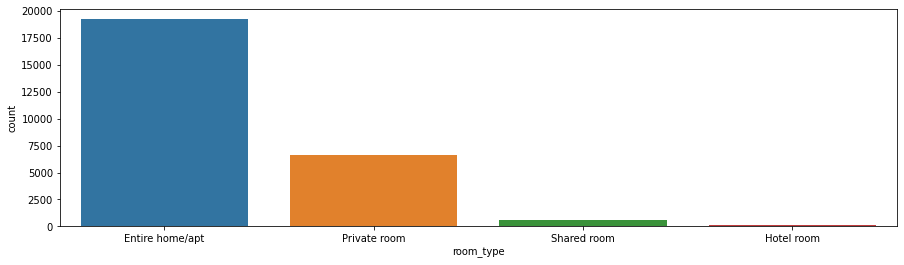

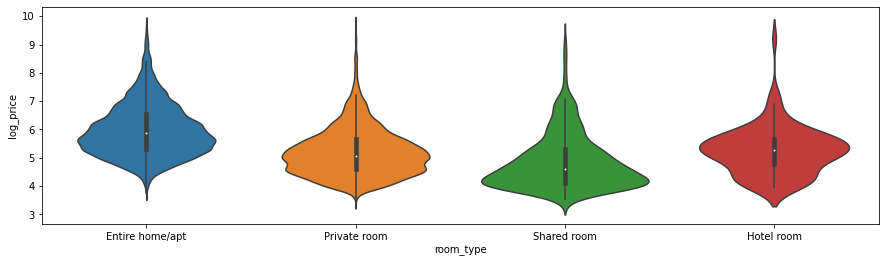

In [94]:
plot_categories_count('room_type', df, violin_col = 'log_price')

In [95]:
one_hot_encode('room_type', df, drop_original_feature = False)

Capacidade de acomodacao

<AxesSubplot:xlabel='accommodates', ylabel='Count'>

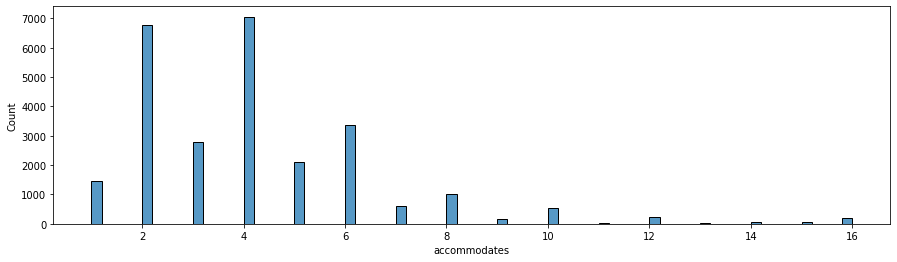

In [96]:
sns.histplot(x = 'accommodates', data = df)

<AxesSubplot:xlabel='accommodates', ylabel='log_price'>

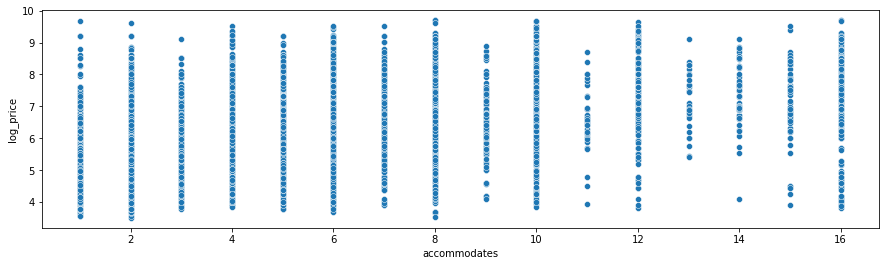

In [97]:
sns.scatterplot(x = 'accommodates', y = 'log_price', data = df)

In [98]:
count_nans('accommodates', df)

 Total de NaNs na coluna accommodates: 0 entre 26530 (0.0%)


Avaliando o numero de banheiros

In [99]:
count_nans('bathrooms', df)

 Total de NaNs na coluna bathrooms: 26530 entre 26530 (100.0%)


In [100]:
non_informative_columns.append('bathrooms')

A coluna bathrooms veio vazia, mas e possivel obter as informacoes sobre numero de banheiros a aprtir da coluna bathroom_text

In [101]:
count_nans('bathrooms_text', df)

 Total de NaNs na coluna bathrooms_text: 65 entre 26530 (0.25%)


In [102]:
df['bathrooms_text'].value_counts()

1 bath               10629
2 baths               5352
1 shared bath         2311
1 private bath        1680
3 baths               1543
1.5 baths             1334
2.5 baths              959
2 shared baths         506
3.5 baths              405
1.5 shared baths       402
4 baths                358
4.5 baths              170
5 baths                135
6 baths                 87
3 shared baths          87
2.5 shared baths        79
5.5 baths               75
7 baths                 59
0 shared baths          41
6.5 baths               39
0 baths                 34
8 baths                 34
4 shared baths          27
3.5 shared baths        23
5 shared baths          16
7.5 baths               16
Shared half-bath        13
Half-bath                8
6 shared baths           6
7 shared baths           4
Private half-bath        4
4.5 shared baths         4
11 baths                 3
8.5 baths                3
10.5 baths               2
6.5 shared baths         2
9 baths                  2
1

Antes de obter o numero, avalia-se se banheiros compartilhados ou nao apresentam diferenca de preco

In [103]:
df['is_bath_shared'] = df['bathrooms_text'].apply(
    lambda x: 1 if 'shared' in str(x) else 0
    )

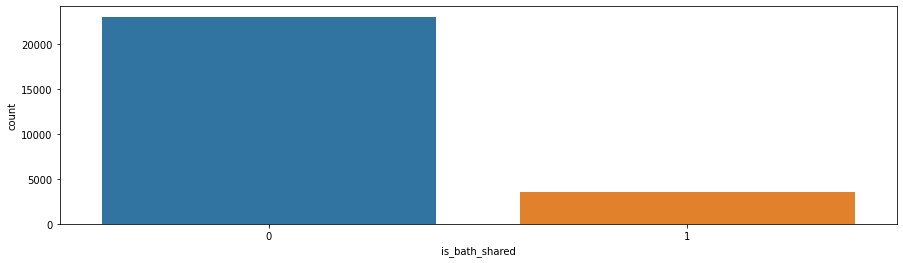

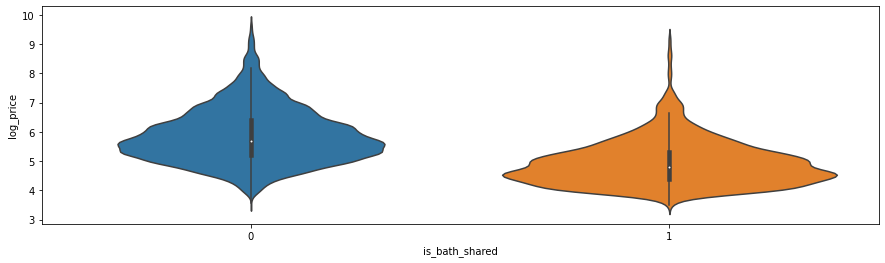

In [104]:
plot_categories_count('is_bath_shared', df, violin_col = 'log_price')

In [105]:
df['bathrooms_num'] = df['bathrooms_text'].str.replace('half', '0.5').str.replace('Half', '0.5')

In [106]:
string_to_numeric('bathrooms_num', df, char_list = ['bath', 'baths', ' ', '-', 'shared', 'private', 'Shared', 'Private'])

<AxesSubplot:xlabel='bathrooms_num', ylabel='Count'>

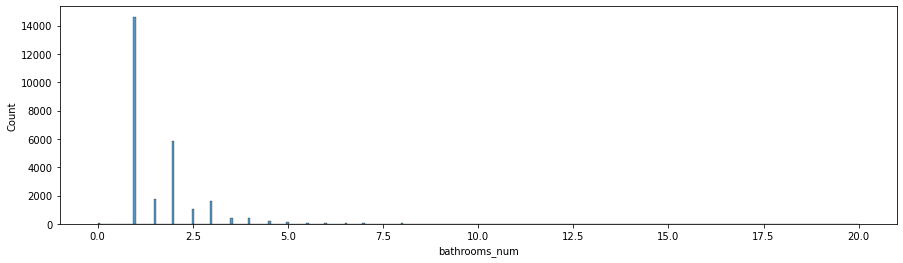

In [107]:
sns.histplot(x = 'bathrooms_num',  data =df)

<AxesSubplot:xlabel='bathrooms_num', ylabel='log_price'>

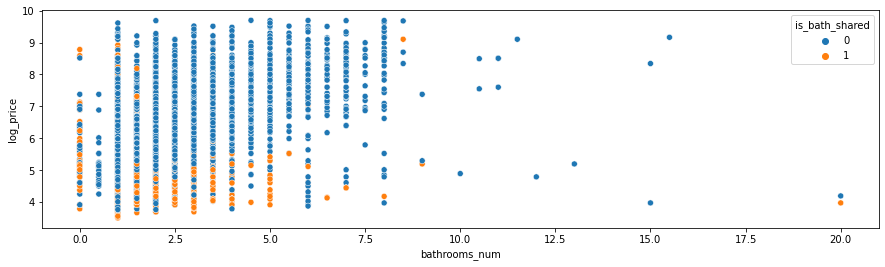

In [108]:
sns.scatterplot(x = 'bathrooms_num', hue = 'is_bath_shared', y = 'log_price', data = df)

In [109]:
non_informative_columns.append('bathrooms_text')

In [110]:
count_nans('bathrooms_num', df)

 Total de NaNs na coluna bathrooms_num: 65 entre 26530 (0.25%)


In [111]:
df['bathrooms_num'].fillna(0, inplace = True)

Avaliando o numero de quartos

In [112]:
count_nans('bedrooms', df)

 Total de NaNs na coluna bedrooms: 1738 entre 26530 (6.550000000000001%)


<AxesSubplot:xlabel='bedrooms', ylabel='Count'>

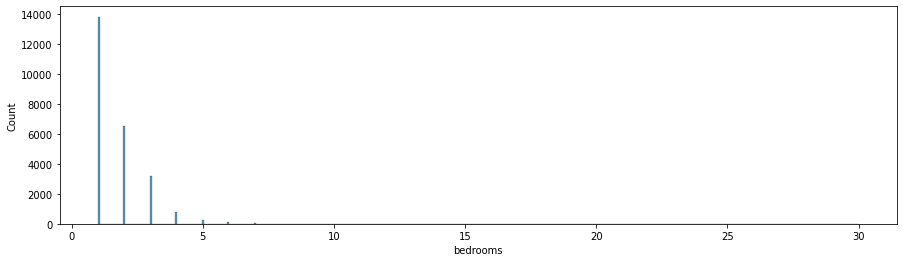

In [113]:
sns.histplot(x = 'bedrooms',  data =df)

<AxesSubplot:xlabel='bedrooms', ylabel='log_price'>

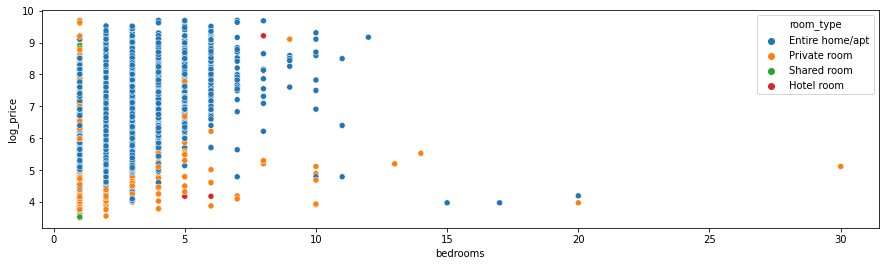

In [114]:
sns.scatterplot(x = 'bedrooms', hue = 'room_type', y = 'log_price', data = df)

In [115]:
df['bedrooms'].fillna(df['bedrooms'].median(), inplace = True)

Avaliando o numero de camas

In [116]:
count_nans('beds', df)

 Total de NaNs na coluna beds: 245 entre 26530 (0.9199999999999999%)


<AxesSubplot:xlabel='beds', ylabel='Count'>

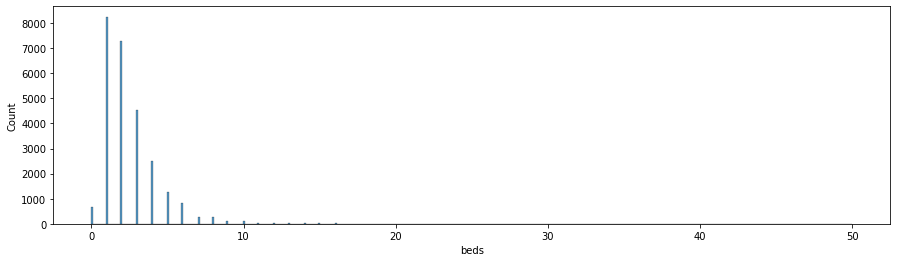

In [117]:
sns.histplot(x = 'beds',  data =df)

<AxesSubplot:xlabel='beds', ylabel='log_price'>

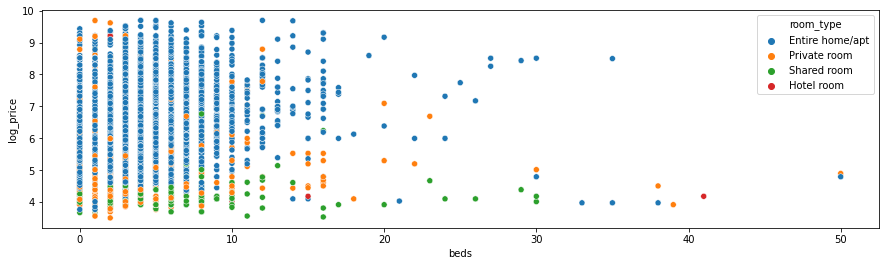

In [118]:
sns.scatterplot(x = 'beds', hue = 'room_type', y = 'log_price', data = df)

In [119]:
df['beds'].fillna(df['beds'].median(), inplace = True)

Avaliando a lista de amenidades

In [120]:
get_uniques_from_list_of_lists('amenities', df)

{'',
 '  Amenities Realgem\\u2019s -Talentos do Brasil Feita a base de mel',
 '  Electrolux refrigerator',
 '  Electrolux stainless steel gas stove',
 '  Electrolux stainless steel oven',
 '  c/ Congelador Separado refrigerator',
 ' 02 Bocas electric stove',
 ' 04 bocas c/forno gas stove',
 ' 1 space',
 ' 100 spaces',
 ' 14\\ TV',
 ' 2 Burner Hot plate electric stove',
 ' 2 bocas electric stove',
 ' 2 bocas portatil electric stove',
 ' 2 caixas de 45w cada',
 ' 2 caixas sony Bluetooth sound system',
 ' 2 in 1. sound system with aux',
 ' 2 spaces',
 ' 2-5 years old',
 ' 20 spaces',
 ' 20\\ HDTV with premium cable',
 ' 20\\ TV',
 ' 22\\ HDTV with Netflix',
 ' 24\\ HDTV with Netflix',
 ' 25\\ TV with Chromecast',
 ' 27\\ HDTV with standard cable',
 ' 27\\ TV',
 ' 28\\ HDTV with Netflix',
 ' 28\\ HDTV with standard cable',
 ' 29\\ TV with standard cable',
 ' 30\\ HDTV with Amazon Prime Video',
 ' 30\\ TV with standard cable',
 ' 32\\ HDTV',
 ' 32\\ HDTV with Amazon Prime Video',
 ' 32\\ HD

In [121]:
selected_categories = ['parking', 'pool', 'Wifi', 'TV', 'gym', 'Air', 'workspace', 'Beach']

>>>>>>>>>>     parking


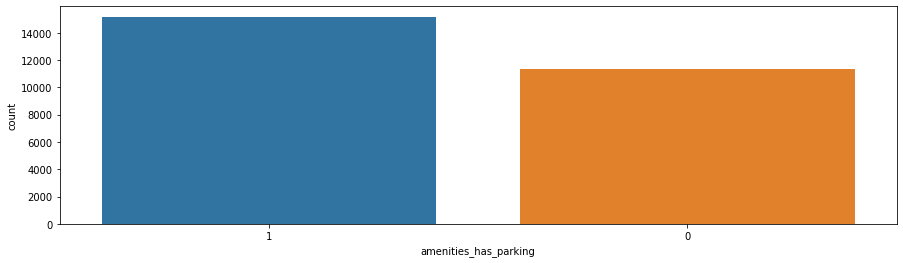

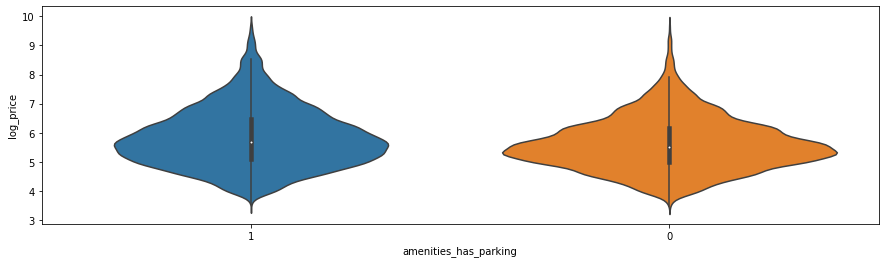

>>>>>>>>>>     pool


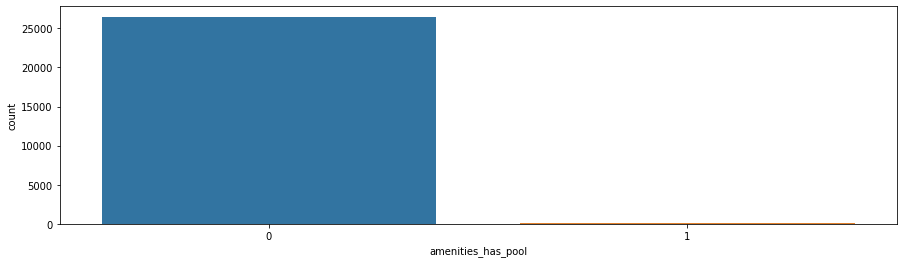

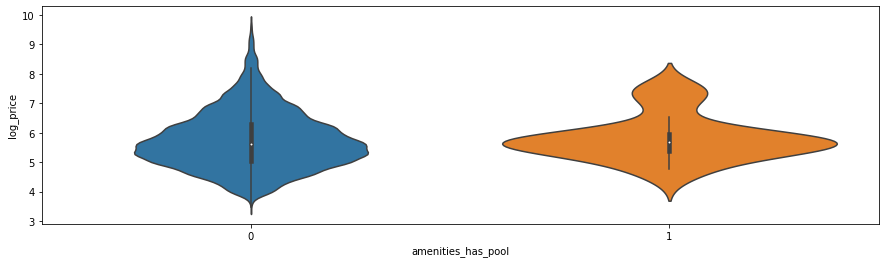

>>>>>>>>>>     Wifi


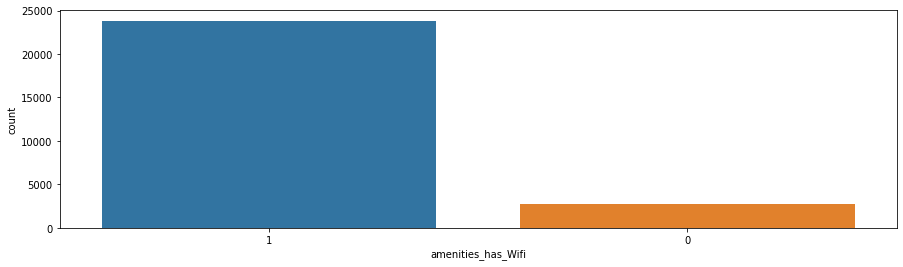

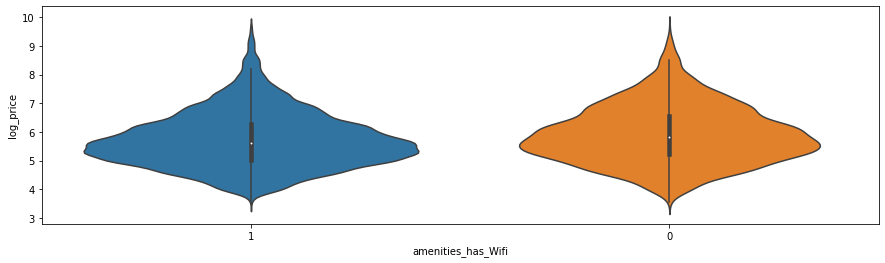

>>>>>>>>>>     TV


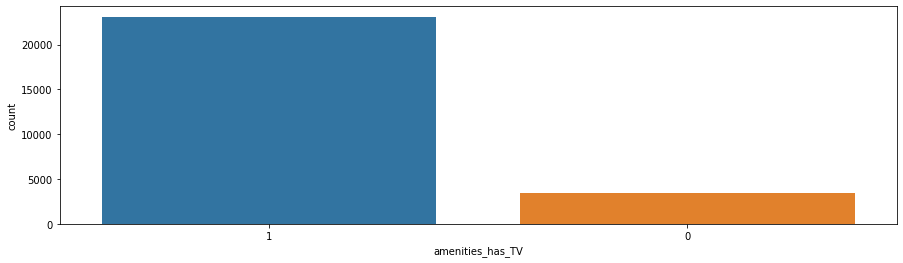

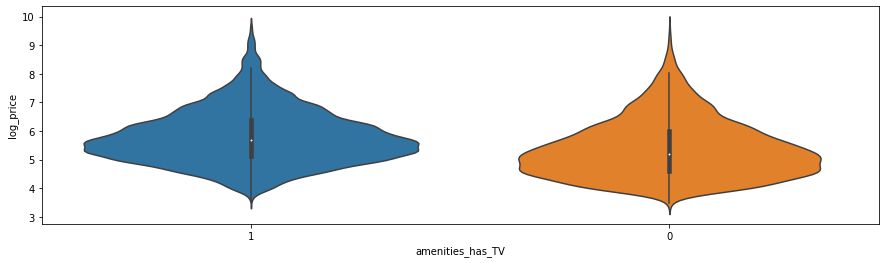

>>>>>>>>>>     gym


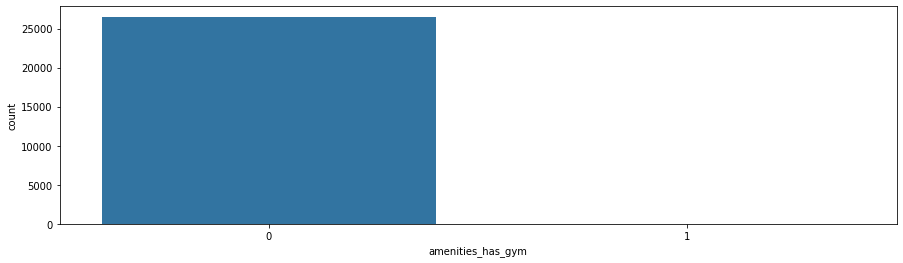

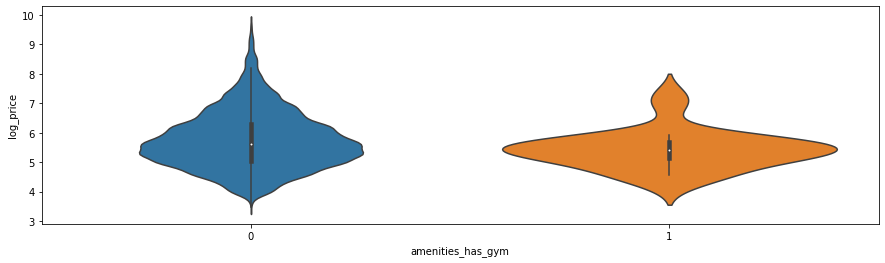

>>>>>>>>>>     Air


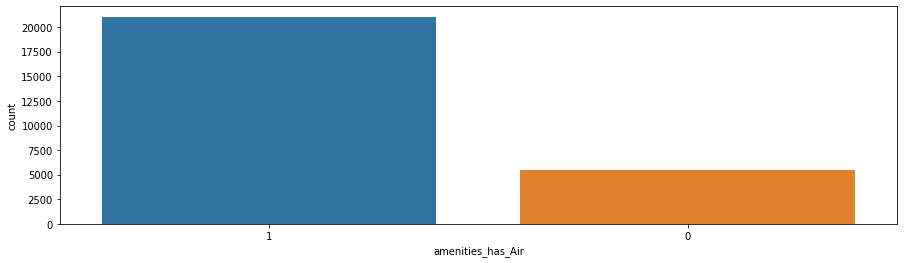

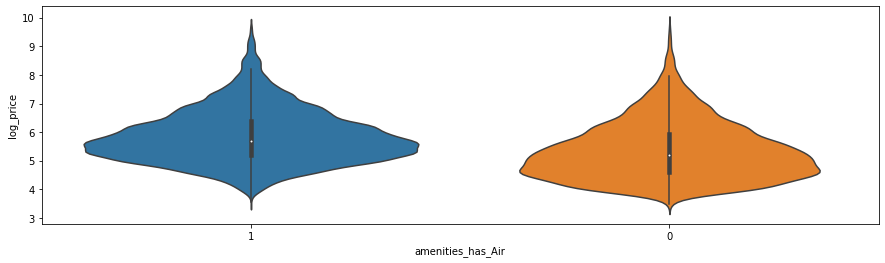

>>>>>>>>>>     workspace


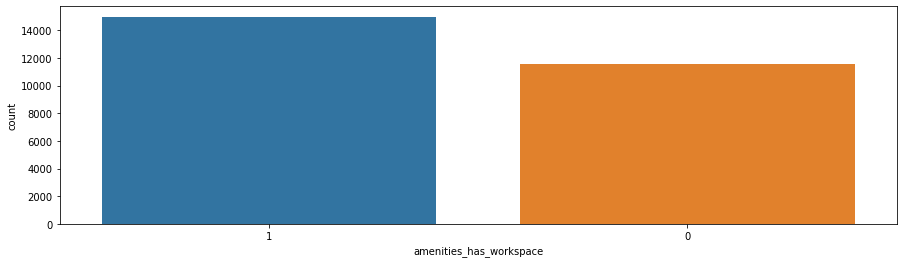

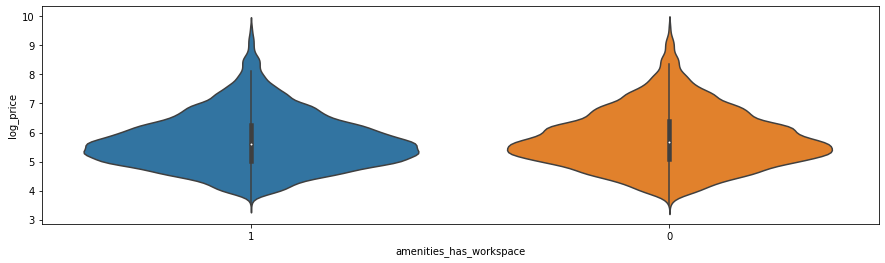

>>>>>>>>>>     Beach


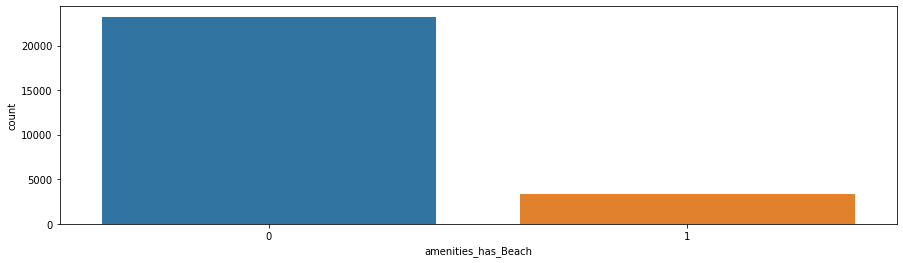

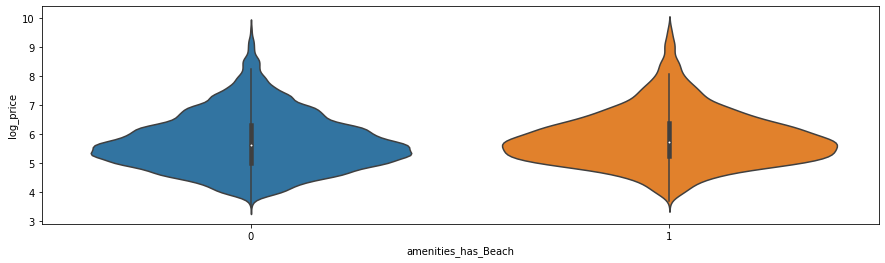

In [122]:
one_hot_encode_selected_categories('amenities', df, selected_categories, violin_col = 'log_price')

In [123]:
non_informative_columns.append('room_type') # room_type ja foi encodado acima e apos uso na analise exploratoria sera removido

### 3.6. Disponibilidade

In [124]:
count_nans('has_availability', df)

 Total de NaNs na coluna has_availability: 0 entre 26530 (0.0%)


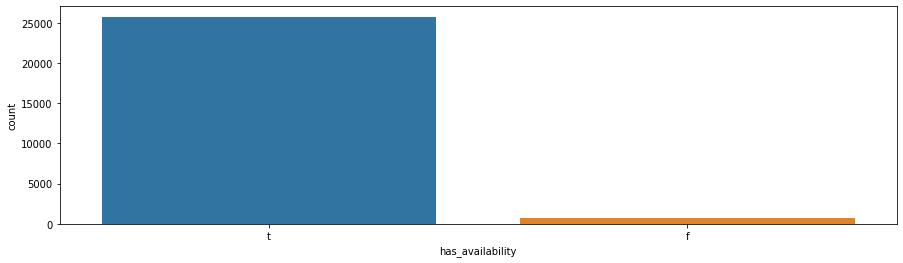

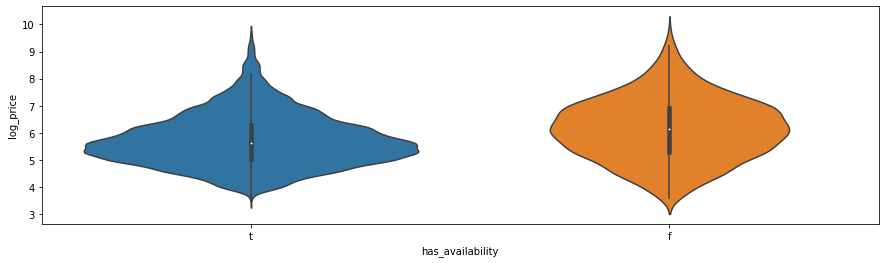

In [125]:
plot_categories_count('has_availability', df, violin_col = 'log_price')

In [126]:
one_hot_encode('has_availability', df)

Disponibilidade 30

In [127]:
count_nans('availability_30', df)

 Total de NaNs na coluna availability_30: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='availability_30', ylabel='Count'>

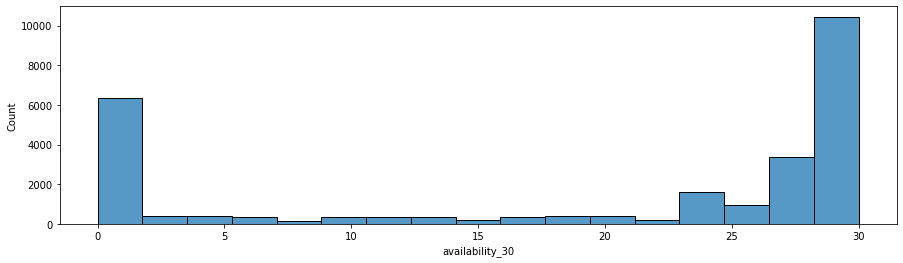

In [128]:
sns.histplot(df['availability_30'])

<AxesSubplot:xlabel='availability_30', ylabel='log_price'>

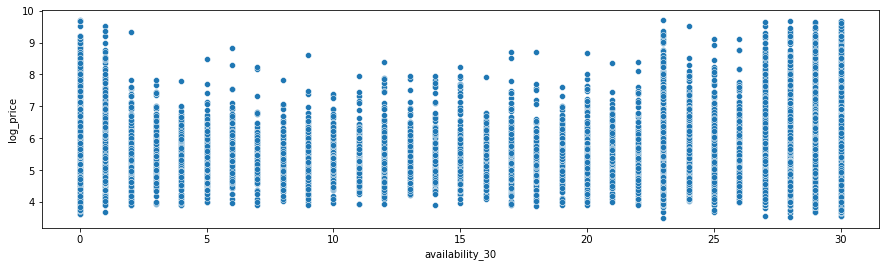

In [129]:
sns.scatterplot(x = 'availability_30', y = 'log_price', data = df)

In [130]:
count_nans('availability_60', df)

 Total de NaNs na coluna availability_60: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='availability_60', ylabel='Count'>

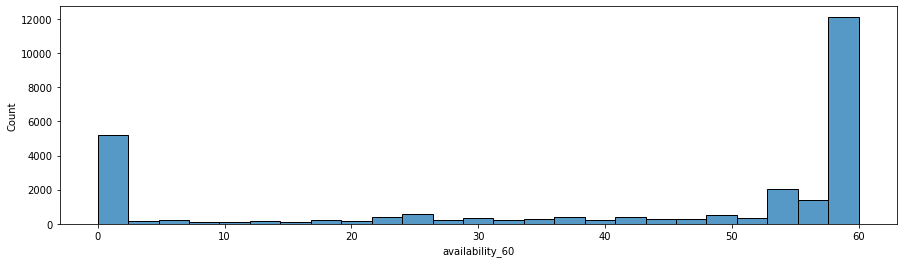

In [131]:
sns.histplot(df['availability_60'])

<AxesSubplot:xlabel='availability_60', ylabel='log_price'>

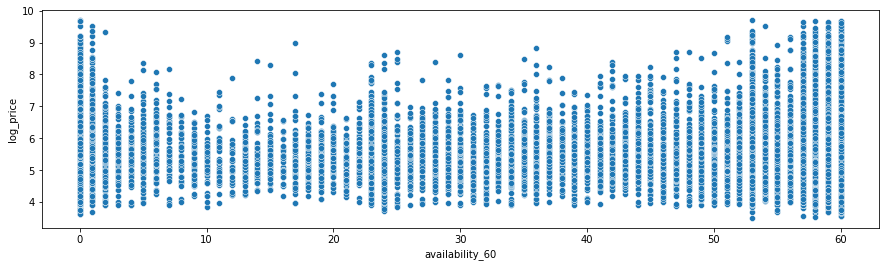

In [132]:
sns.scatterplot(x = 'availability_60', y = 'log_price', data = df)

In [133]:
count_nans('availability_90', df)

 Total de NaNs na coluna availability_90: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='availability_90', ylabel='Count'>

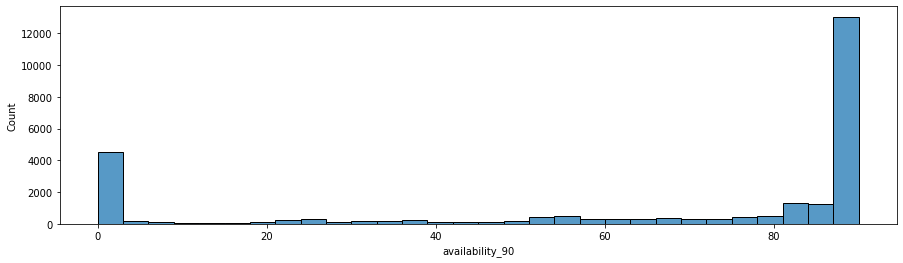

In [134]:
sns.histplot(df['availability_90'])

<AxesSubplot:xlabel='availability_90', ylabel='log_price'>

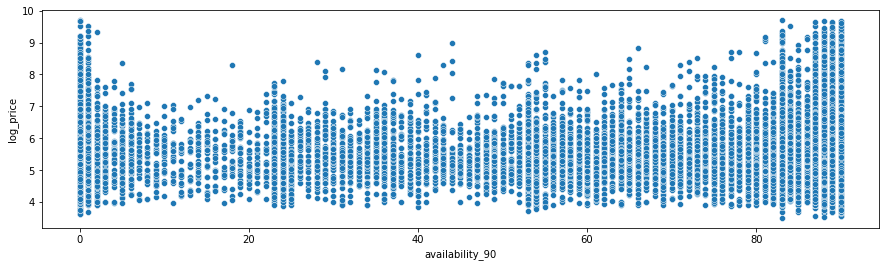

In [135]:
sns.scatterplot(x = 'availability_90', y = 'log_price', data = df)

In [136]:
count_nans('availability_365', df)

 Total de NaNs na coluna availability_365: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='availability_365', ylabel='Count'>

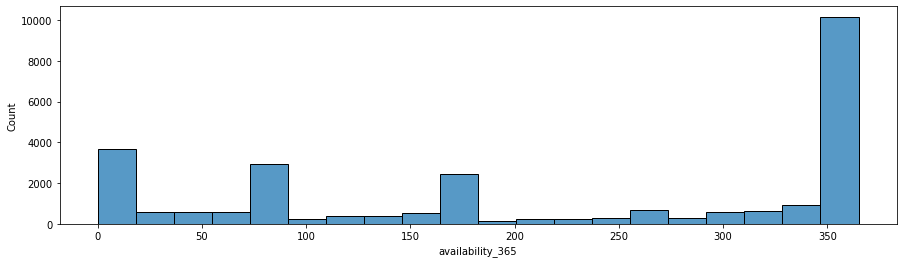

In [137]:
sns.histplot(df['availability_365'])

<AxesSubplot:xlabel='availability_365', ylabel='log_price'>

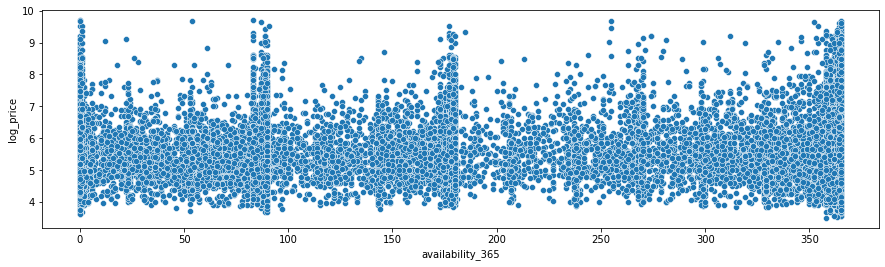

In [138]:
sns.scatterplot(x = 'availability_365', y = 'log_price', data = df)

In [139]:
count_nans('instant_bookable', df)

 Total de NaNs na coluna instant_bookable: 0 entre 26530 (0.0%)


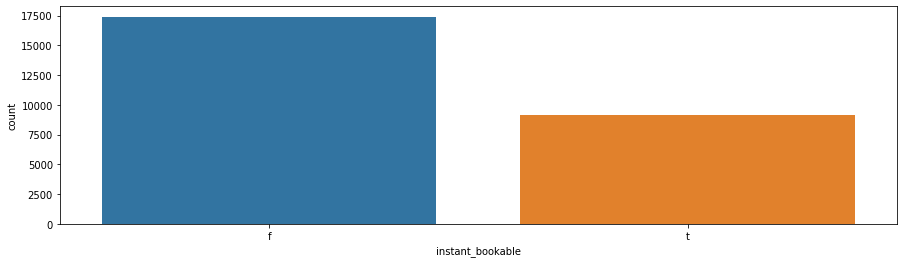

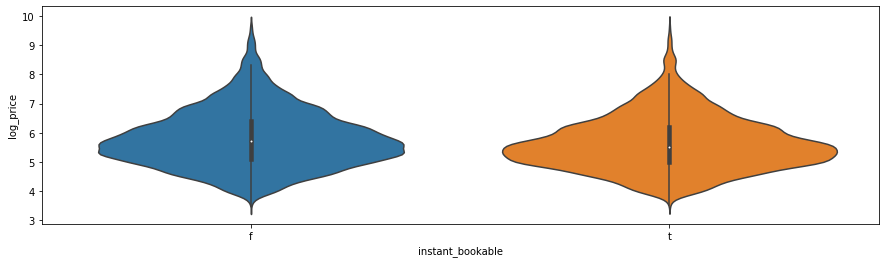

In [140]:
plot_categories_count('instant_bookable', df, violin_col = 'log_price')

In [141]:
one_hot_encode('instant_bookable', df)

In [142]:
count_nans('calendar_updated', df)

 Total de NaNs na coluna calendar_updated: 26530 entre 26530 (100.0%)


In [143]:
non_informative_columns.append('calendar_updated')

In [144]:
count_nans('calendar_last_scraped', df)

 Total de NaNs na coluna calendar_last_scraped: 0 entre 26530 (0.0%)


In [145]:
date_to_numeric('calendar_last_scraped', df)

<AxesSubplot:xlabel='calendar_last_scraped', ylabel='Count'>

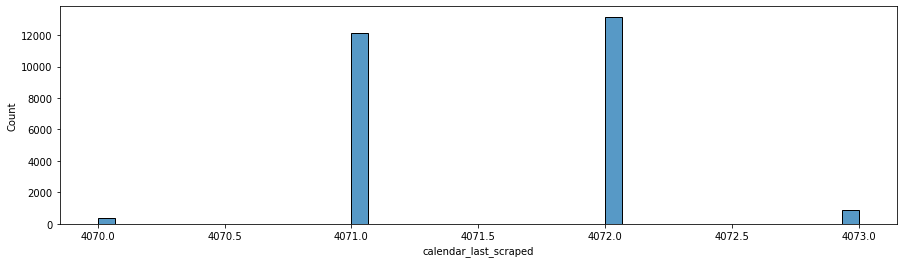

In [146]:
sns.histplot(x = 'calendar_last_scraped', data = df)

### 3.8. Reviews

Avaliando 'number_of_reviews'

In [147]:
count_nans('number_of_reviews', df)

 Total de NaNs na coluna number_of_reviews: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='number_of_reviews', ylabel='Count'>

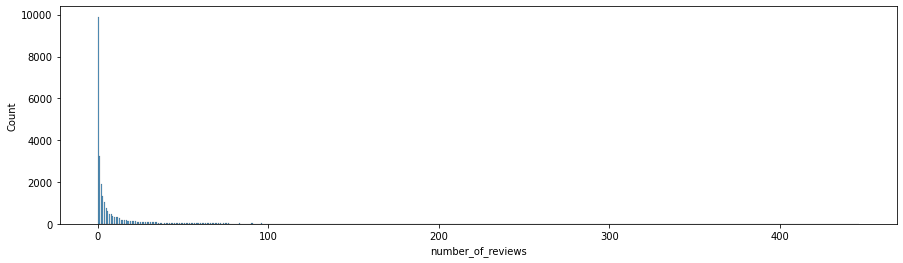

In [148]:
sns.histplot(x = 'number_of_reviews', data = df)

<AxesSubplot:xlabel='number_of_reviews', ylabel='log_price'>

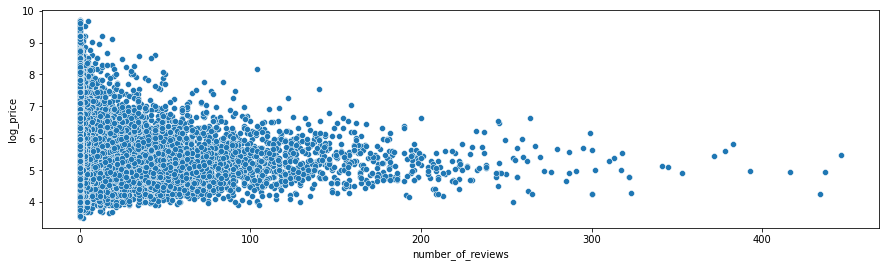

In [149]:
sns.scatterplot(x = 'number_of_reviews', y = 'log_price', data = df)

In [150]:
count_nans('number_of_reviews_ltm', df)

 Total de NaNs na coluna number_of_reviews_ltm: 0 entre 26530 (0.0%)


<AxesSubplot:xlabel='number_of_reviews_ltm', ylabel='Count'>

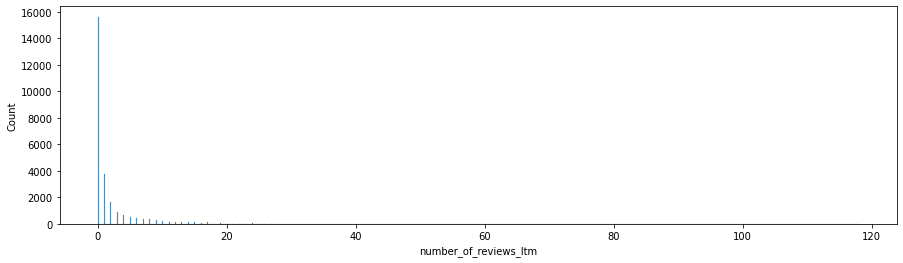

In [151]:
sns.histplot(x = 'number_of_reviews_ltm', data = df)

<AxesSubplot:xlabel='number_of_reviews_ltm', ylabel='log_price'>

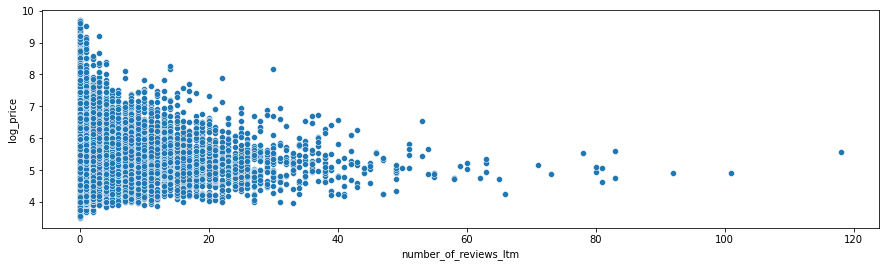

In [152]:
sns.scatterplot(x = 'number_of_reviews_ltm', y = 'log_price', data = df)

Ha correlcacao entre number_of_reviews_ltm e number_of_reviews?

<AxesSubplot:xlabel='number_of_reviews_ltm', ylabel='number_of_reviews'>

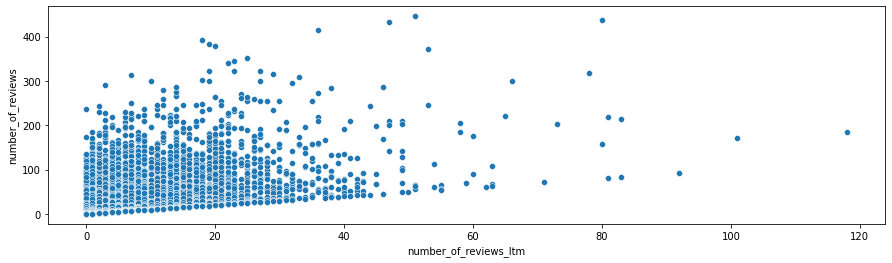

In [153]:
sns.scatterplot(x = 'number_of_reviews_ltm', y = 'number_of_reviews', data = df)

In [154]:
count_nans('first_review', df)

 Total de NaNs na coluna first_review: 9899 entre 26530 (37.31%)


In [155]:
date_to_numeric('first_review', df)

<AxesSubplot:xlabel='first_review', ylabel='Count'>

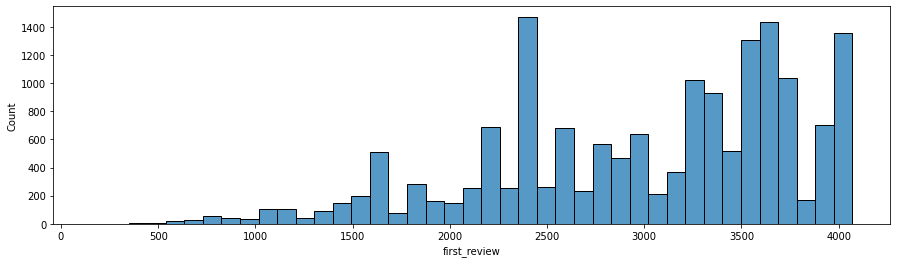

In [156]:
sns.histplot(x='first_review', data = df)

<AxesSubplot:xlabel='first_review', ylabel='log_price'>

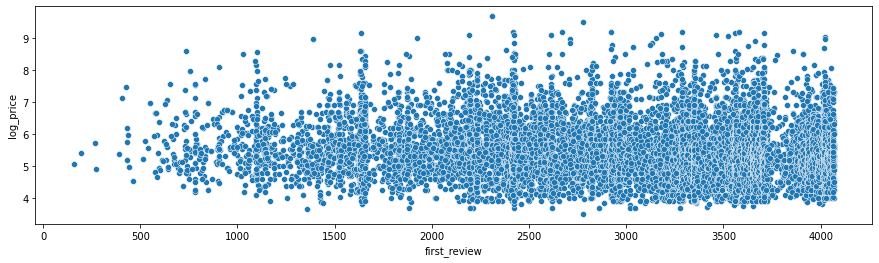

In [157]:
sns.scatterplot(x = 'first_review', y = 'log_price', data = df)

In [158]:
df['first_review'].fillna(5000, inplace = True) # preenchendo com um numero maior do que o maximo encontrado na base

In [159]:
count_nans('last_review', df)

 Total de NaNs na coluna last_review: 9899 entre 26530 (37.31%)


In [160]:
date_to_numeric('last_review', df)

<AxesSubplot:xlabel='last_review', ylabel='Count'>

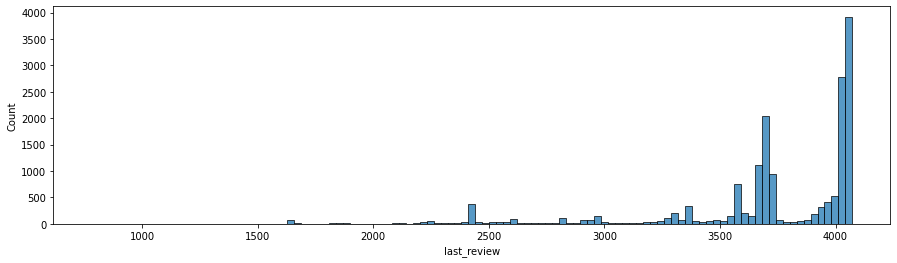

In [161]:
sns.histplot(x = 'last_review', data = df)

<AxesSubplot:xlabel='last_review', ylabel='log_price'>

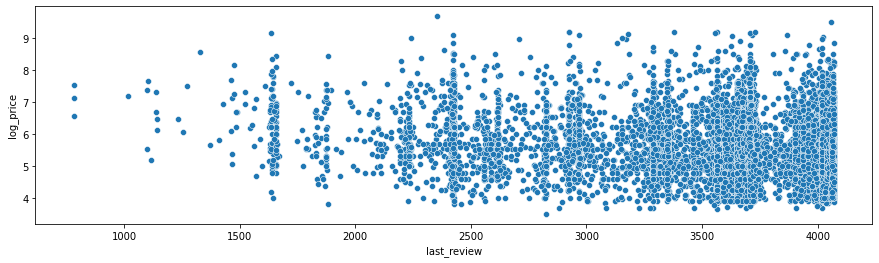

In [162]:
sns.scatterplot(x = 'last_review', y = 'log_price', data = df)

In [163]:
df['last_review'].fillna(5000, inplace = True) # preenchendo com um numero maior do que o maximo encontrado na base

In [164]:
count_nans('reviews_per_month', df)

 Total de NaNs na coluna reviews_per_month: 9899 entre 26530 (37.31%)


<AxesSubplot:xlabel='reviews_per_month', ylabel='Count'>

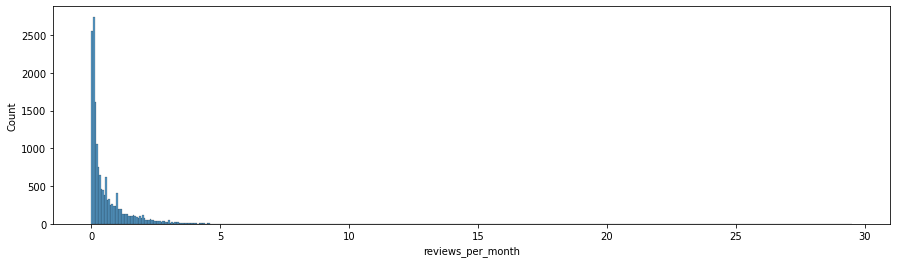

In [165]:
sns.histplot(x = 'reviews_per_month', data = df)

<AxesSubplot:xlabel='reviews_per_month', ylabel='log_price'>

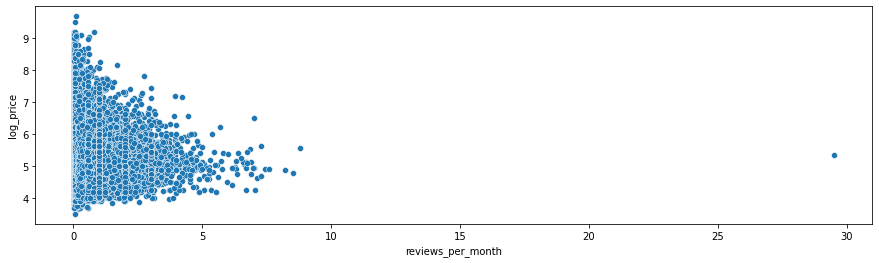

In [166]:
sns.scatterplot(x = 'reviews_per_month', y = 'log_price', data = df)

In [167]:
df['reviews_per_month'].fillna(0, inplace = True)

In [168]:
count_nans('license', df)

 Total de NaNs na coluna license: 26530 entre 26530 (100.0%)


In [169]:
non_informative_columns.append('license')

In [170]:
count_nans('review_scores_rating', df)

 Total de NaNs na coluna review_scores_rating: 10436 entre 26530 (39.34%)


<AxesSubplot:xlabel='review_scores_rating', ylabel='Count'>

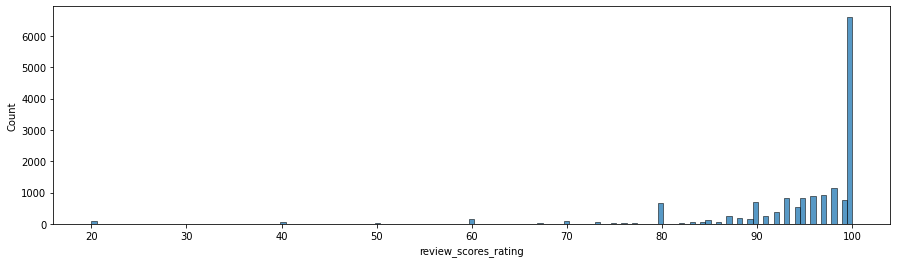

In [171]:
sns.histplot(x = 'review_scores_rating', data = df)

<AxesSubplot:xlabel='review_scores_rating', ylabel='log_price'>

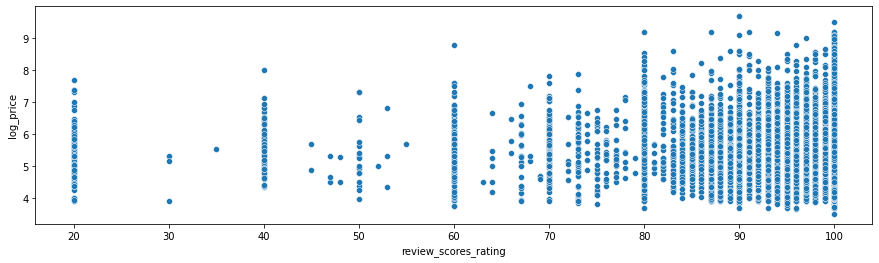

In [172]:
sns.scatterplot(x = 'review_scores_rating', y = 'log_price', data = df)

In [173]:
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace = True)

<AxesSubplot:>

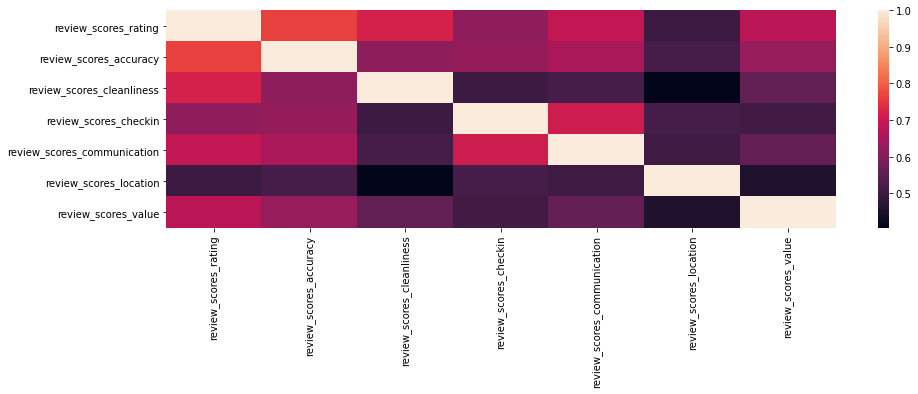

In [174]:
review_scores = [x for x in df.columns if 'review_scores' in x]
sns.heatmap(df[review_scores].corr())

In [175]:
count_nans('review_scores_location', df)

 Total de NaNs na coluna review_scores_location: 10448 entre 26530 (39.379999999999995%)


<AxesSubplot:xlabel='review_scores_location', ylabel='Count'>

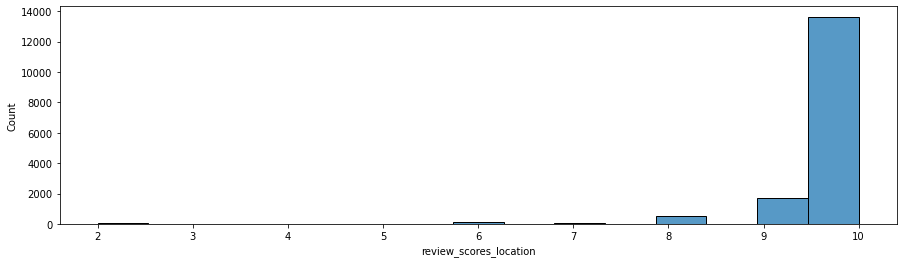

In [176]:
sns.histplot(x = 'review_scores_location', data = df)

<AxesSubplot:xlabel='review_scores_location', ylabel='log_price'>

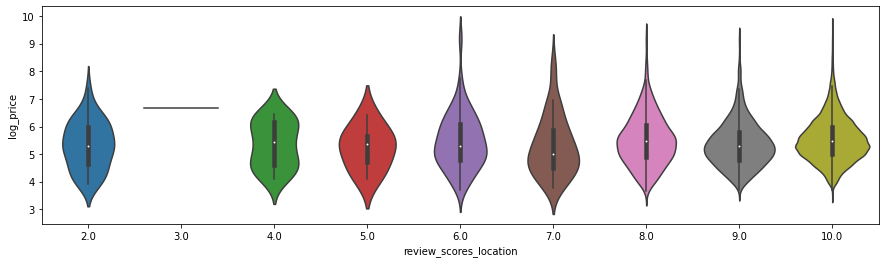

In [177]:
sns.violinplot(x = 'review_scores_location', y = 'log_price', data = df)

In [178]:
df['review_scores_location'].fillna(df['review_scores_location'].median(), inplace = True)

In [179]:
non_informative_columns.extend(
    [
        'review_scores_accuracy',
         'review_scores_cleanliness',
         'review_scores_checkin',
         'review_scores_communication',
         'review_scores_value',
    ]
)

### 3.9. Permanencia minima e máxima

In [180]:
count_nans('minimum_nights', df)

 Total de NaNs na coluna minimum_nights: 0 entre 26530 (0.0%)


In [181]:
df['minimum_nights'].describe()

count    26530.000000
mean         4.699962
std         19.070367
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1000.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:xlabel='minimum_nights', ylabel='Count'>

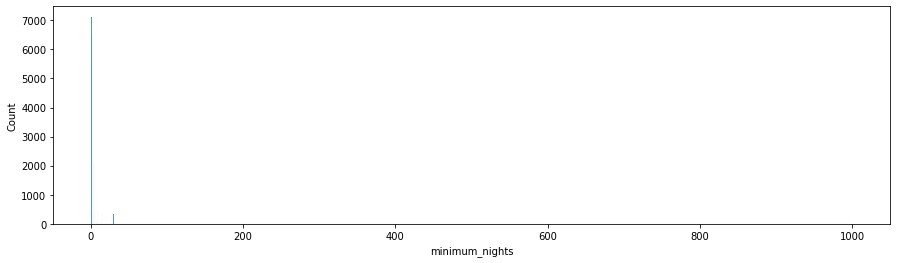

In [182]:
sns.histplot(x = 'minimum_nights', data = df)

<AxesSubplot:>

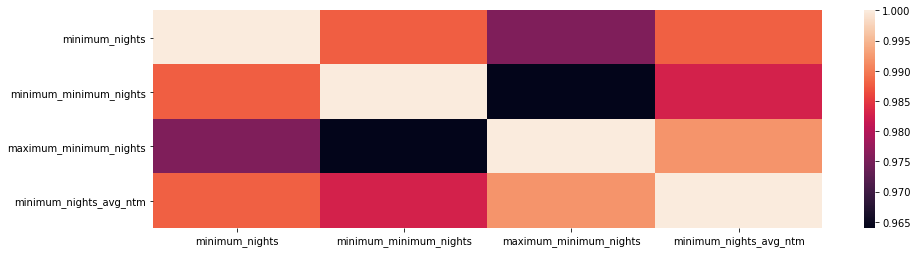

In [183]:
cols = [
     'minimum_nights',
     'minimum_minimum_nights',
     'maximum_minimum_nights',
     'minimum_nights_avg_ntm',
]

sns.heatmap(df[cols].corr())

In [184]:
non_informative_columns.extend(
    [
         'minimum_minimum_nights',
         'maximum_minimum_nights',
         'minimum_nights_avg_ntm',
    ]
)

maximum_nights apresenta valores extremamente altos que tornam o cálculo de metodos como .describe muito demorados. Sendo assim, esses valores absurdos serão substituidos pelo máximo dos valores não absurdos.

In [185]:
df['maximum_nights'].max()

999999999

In [186]:
replace_infinity('maximum_nights', df)
replace_infinity('maximum_nights_avg_ntm', df)
replace_infinity('minimum_maximum_nights', df)
replace_infinity('maximum_maximum_nights', df)

Encontradas 3 entradas superiores a 10000.0 na coluna maximum_nights. Esses valores foram susbtituidos por 3500
Encontradas 3 entradas superiores a 10000.0 na coluna maximum_nights_avg_ntm. Esses valores foram susbtituidos por 2000.0
Encontradas 3 entradas superiores a 10000.0 na coluna minimum_maximum_nights. Esses valores foram susbtituidos por 2000.0
Encontradas 3 entradas superiores a 10000.0 na coluna maximum_maximum_nights. Esses valores foram susbtituidos por 9999.0


<AxesSubplot:>

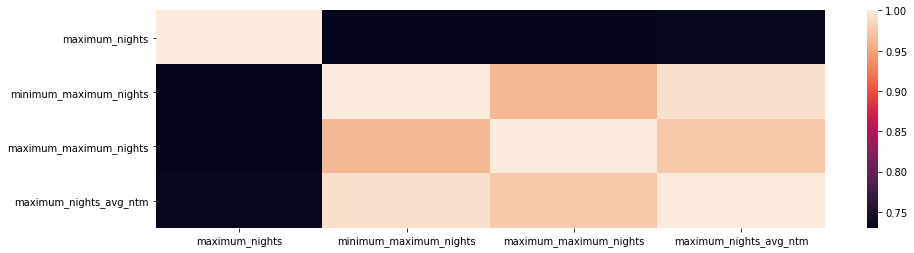

In [187]:
cols = [
     'maximum_nights',
     'minimum_maximum_nights',
     'maximum_maximum_nights',
     'maximum_nights_avg_ntm',
]

sns.heatmap(df[cols].corr())

A coluna maximum_nights nao apresenta a mesma correlacao com as outras colunas de maximum night.

<AxesSubplot:xlabel='maximum_nights', ylabel='Count'>

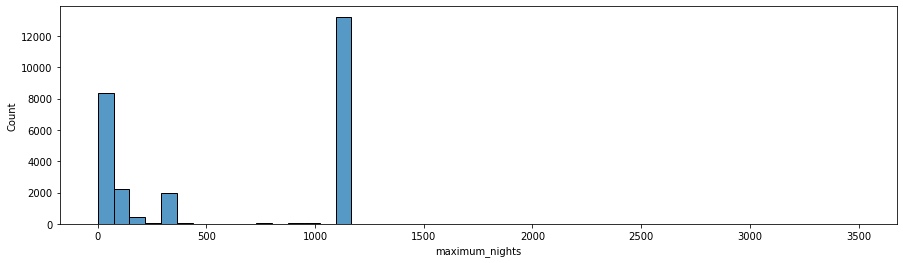

In [188]:
sns.histplot(x = 'maximum_nights', data = df)

<AxesSubplot:xlabel='maximum_nights', ylabel='log_price'>

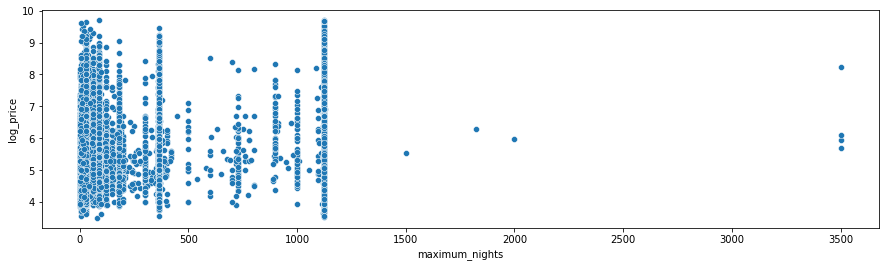

In [189]:
sns.scatterplot(x = 'maximum_nights', y = 'log_price', data = df)

<AxesSubplot:xlabel='maximum_nights', ylabel='maximum_nights_avg_ntm'>

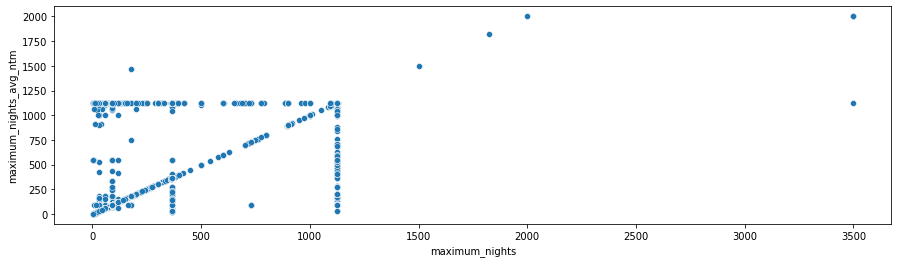

In [190]:
sns.scatterplot(x = 'maximum_nights', y = 'maximum_nights_avg_ntm', data = df)

<AxesSubplot:xlabel='maximum_nights_avg_ntm', ylabel='Count'>

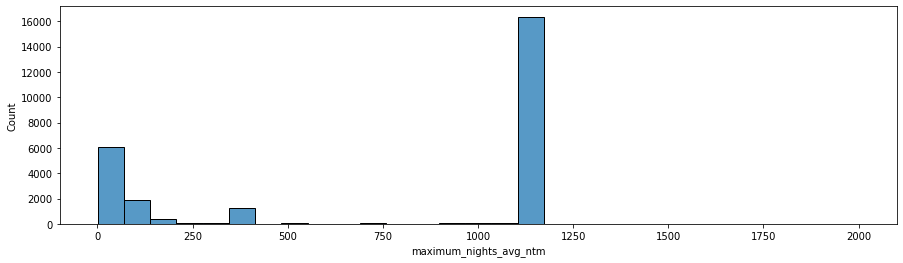

In [191]:
sns.histplot(x = 'maximum_nights_avg_ntm', data = df)

As colunas 'minimum_maximum_nights' e 'maximum_maximum_nights' sao altamente correlacionadas com a maximum_nights_avg_ntm e serao eliminadas. Como a coluna maximum_night nao apresenta correlacao com a coluna maximum_nights_avg_ntm, ambas serao mantidas para que o algoritmo de feature selection tome a decisao de as manter ou nao.

In [192]:
non_informative_columns.extend(
    [
         'minimum_maximum_nights',
         'maximum_maximum_nights',
    ]
)

### 3.6. Eliminando as colunas que não serão utilizadas

In [193]:
colunas_nao_exploradas = [
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
]
non_informative_columns.extend(colunas_nao_exploradas)

In [194]:
df.drop(columns = non_informative_columns, inplace = True)
df.drop(columns = text_columns, inplace = True)

## 4. Machine Learning 

Utiliza-se um pipeline entre RFE para selecao de features e um Gradiente Boosting com busca randomizada

In [195]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

Classe para integrar gridsearch dentro do estimador do RFE foi adaptada do codigo disponivel em: <br>
https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

In [196]:
class MyPipe(Pipeline):

    def fit(self, X, y=None, **fit_params):
        """Calls last elements .coef_ method.
        Based on the sourcecode for decision_function(X).
        Link: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py
        ----------
        """
        super(MyPipe, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].feature_importances_
        return self

In [197]:
target = 'log_price'

In [198]:
x, y = df.drop(columns = target), df.loc[:, target]

In [199]:
gdbr = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 0.02, random_state = seed, loss = 'lad')

estimator = MyPipe([('gdbr', gdbr)])

selector = RFE(estimator, n_features_to_select = 0.2)

In [200]:
param_grid = {
    'n_features_to_select': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'estimator__gdbr__max_depth': [3, 5, 6, 7, 8, 9, 11],
    'estimator__gdbr__min_samples_leaf': [0.0025, 0.005, 0.01, 0.015, 0.025, 0.05, 0.15, 0.25],
}

cv_search = RandomizedSearchCV(
    selector,
    n_iter = 100,
    param_distributions = param_grid,
    return_train_score = True,
    random_state = seed,
    verbose = 10,
    n_jobs = -1,
    )

cv_search.fit(x, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=RFE(estimator=MyPipe(steps=[('gdbr',
                                                          GradientBoostingRegressor(loss='lad',
                                                                                    min_samples_leaf=0.02,
                                                                                    random_state=0))]),
                                 n_features_to_select=0.2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__gdbr__max_depth': [3, 5, 6,
                                                                       7, 8, 9,
                                                                       11],
                                        'estimator__gdbr__min_samples_leaf': [0.0025,
                                                                              0.005,
                                                                              0.01,
                                  

In [201]:
cv_search.cv_results_

{'mean_fit_time': array([ 336.3297987 , 1019.56200352,  255.32652235,  496.34544754,
          88.07555299,  463.48725243,  680.30093989,  155.60784259,
         303.89557576,  139.70286746,   80.24960527,  266.47127037,
         773.18679776,  155.83451538,  931.18218565,  941.46105275,
         155.1014935 ,  304.05009513,  595.97524109,  642.73868313,
         119.35281668,  204.67647986,  380.37738724,  221.47510486,
         260.32923398,  241.74822307, 1214.78085299,  595.14916463,
          56.092065  ,  438.32959642,  457.61703582,  677.00158424,
         172.04067874,  547.46309037,  157.69396935,  495.92927265,
         121.78276825,  162.82033467,  417.35990195,  104.64812059,
         281.86595125,  127.6076508 ,  449.95342088,  540.9533648 ,
         854.10635424,  301.31126966,  610.76023879,  493.27266216,
         141.49701858,  156.9455585 ,  187.71668396,  222.34139395,
         147.6732316 ,  172.80443792,  539.4908958 ,  452.66914487,
         619.25063543,  608.556

In [202]:
cv_results = cv_search.cv_results_

model_selection = pd.DataFrame.from_dict(
        {
            'diff_mean': cv_results['mean_train_score'] - cv_results['mean_test_score'],
            'mean_test_score': cv_results['mean_test_score'],
            'std_test_score': cv_results['std_test_score']
        }
    )

In [203]:
model_selection.sort_values(by = ['diff_mean', 'mean_test_score', 'std_test_score'], ascending = [True, False, True])

,diff_mean,mean_test_score,std_test_score
25,0.056022,0.562399,0.024772
84,0.056064,0.575148,0.029085
23,0.056693,0.516085,0.020168
74,0.056693,0.516085,0.020168
52,0.056703,0.575751,0.027156
...,...,...,...
14,0.121430,0.562805,0.028308
72,0.129430,0.605047,0.018358
96,0.147970,0.606432,0.018926
1,0.155134,0.541943,0.025123


In [247]:
mean_test_threshold = 0.575
diff_mean_threshold = 0.06

model_selection['is_model_good'] = (model_selection['diff_mean'] < diff_mean_threshold) & (model_selection['mean_test_score'] > mean_test_threshold)

In [250]:
model_selection[model_selection['is_model_good']]

,diff_mean,mean_test_score,std_test_score,is_model_good
39,0.058197,0.578658,0.028006,True
52,0.056703,0.575751,0.027156,True
63,0.059332,0.577389,0.028173,True
68,0.056928,0.576306,0.025778,True
84,0.056064,0.575148,0.029085,True


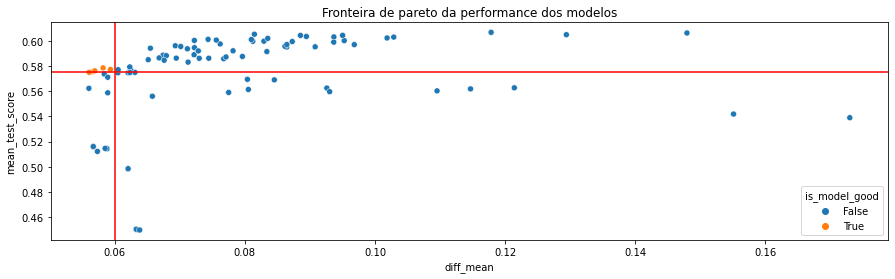

In [249]:
ax = sns.scatterplot(x = 'diff_mean', y = 'mean_test_score', hue = 'is_model_good', data = model_selection)
plt.axhline(mean_test_threshold, c = 'r')
plt.axvline(diff_mean_threshold, c = 'r')
plt.title('Fronteira de pareto da performance dos modelos')
plt.show()

In [254]:
modelo_escolhido = 39
best_params = cv_results['params'][modelo_escolhido]
print(best_params)

{'n_features_to_select': 0.8, 'estimator__gdbr__min_samples_leaf': 0.0025, 'estimator__gdbr__max_depth': 3}


In [255]:
best_gdbr = GradientBoostingRegressor(
    n_estimators = 100,
    max_depth = best_params['estimator__gdbr__max_depth'],
    min_samples_leaf = best_params['estimator__gdbr__min_samples_leaf'],
    random_state = seed,
    loss = 'lad',
    )

best_model = RFE(best_gdbr, n_features_to_select = best_params['n_features_to_select'])

In [256]:
best_model.fit(x, y)

RFE(estimator=GradientBoostingRegressor(loss='lad', min_samples_leaf=0.0025,
                                        random_state=0),
    n_features_to_select=0.8)

In [257]:
y_pred = best_model.predict(x)

In [258]:
df['erro_percentual'] = (y_pred - y)/y*100

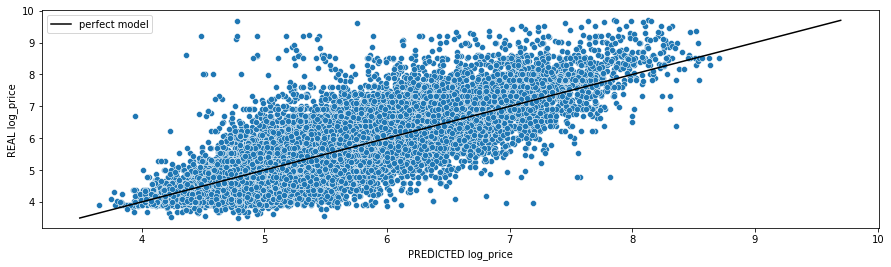

In [259]:
ax = sns.scatterplot(x = y_pred, y = y)
diag = [y.min(), y.max()]
ax.plot(diag, diag, c = 'k', label = 'perfect model')
ax.set_xlabel(f'PREDICTED {target}')
ax.set_ylabel(f'REAL {target}')
ax.legend()
plt.show()

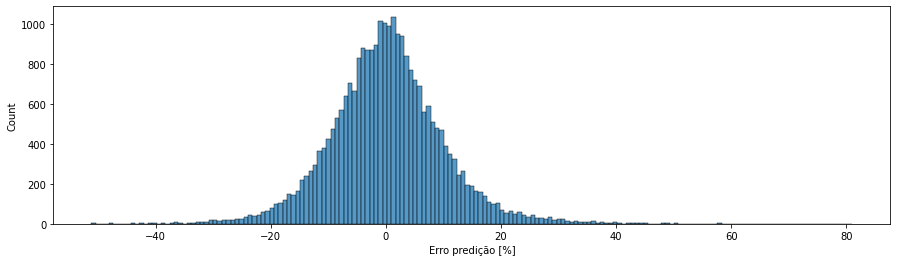

In [260]:
ax = sns.histplot(x = 'erro_percentual', data = df)
ax.set_xlabel('Erro predição [%]')
plt.show()

Avalia-se a distirbuicao dos erros entre as categorias para entender se ha alguma com dificuldades em particular

>>>>>>>>>>     room_type_is_Entire home/apt


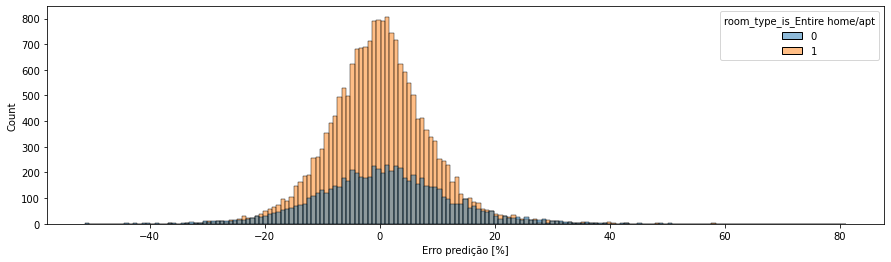

>>>>>>>>>>     room_type_is_Private room


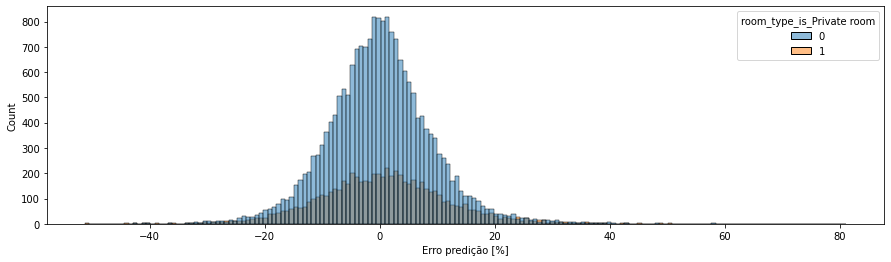

>>>>>>>>>>     room_type_is_Shared room


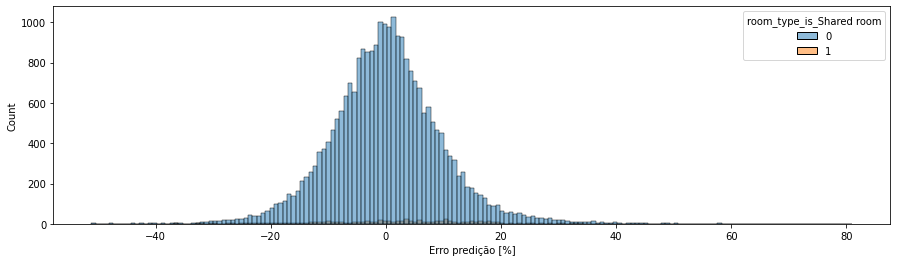

In [261]:
hue_cols = [
    'room_type_is_Entire home/apt',
    'room_type_is_Private room',
    'room_type_is_Shared room'
]

for hue in hue_cols:
    print('>'*10, ' '*3, hue)
    ax = sns.histplot(x = 'erro_percentual', hue = hue, data = df)
    ax.set_xlabel('Erro predição [%]')
    plt.show()

>>>>>>>>>>     neighbourhood_cleansed_is_Copacabana


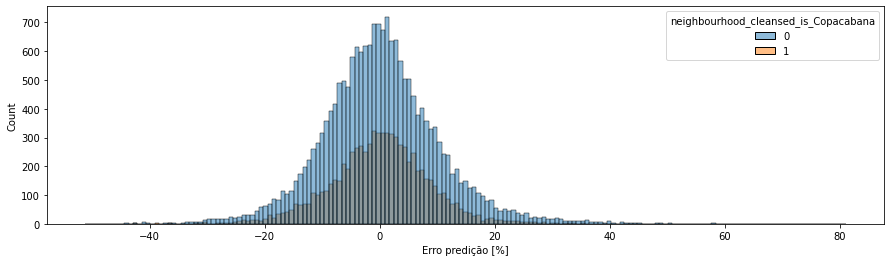

>>>>>>>>>>     neighbourhood_cleansed_is_Barra da Tijuca


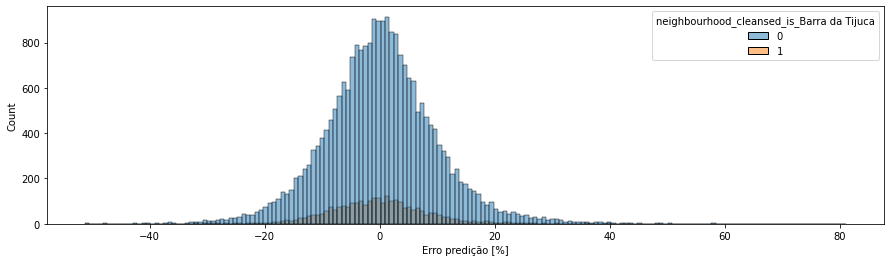

>>>>>>>>>>     neighbourhood_cleansed_is_Ipanema


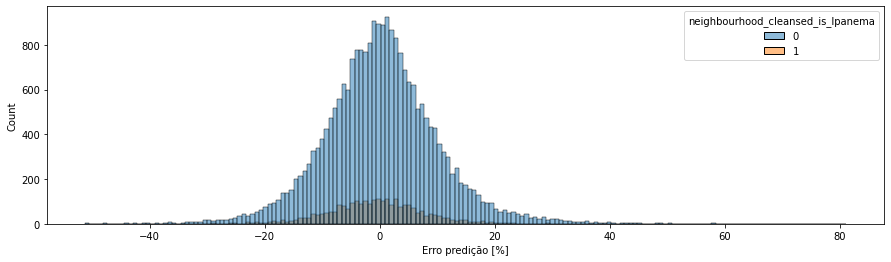

>>>>>>>>>>     neighbourhood_cleansed_is_Jacarepaguá


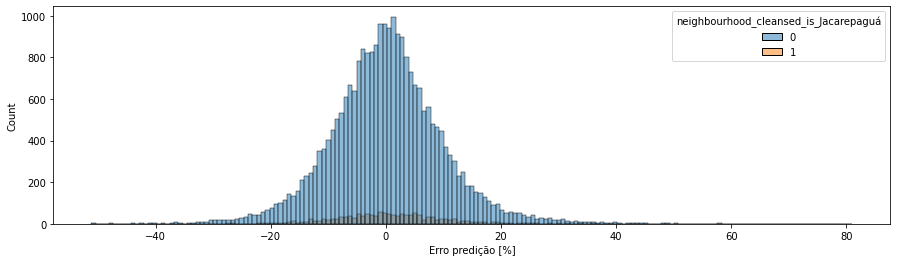

>>>>>>>>>>     neighbourhood_cleansed_is_Botafogo


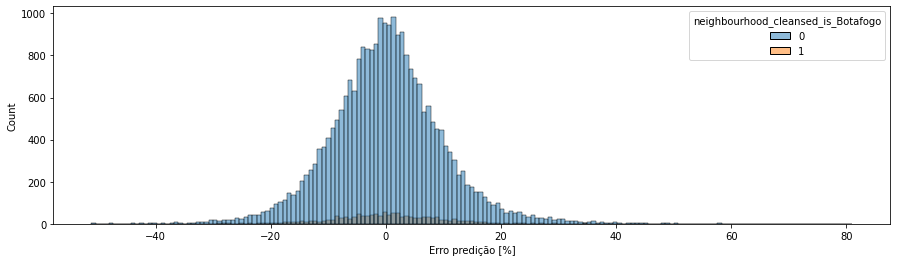

>>>>>>>>>>     neighbourhood_cleansed_is_Recreio dos Bandeirantes


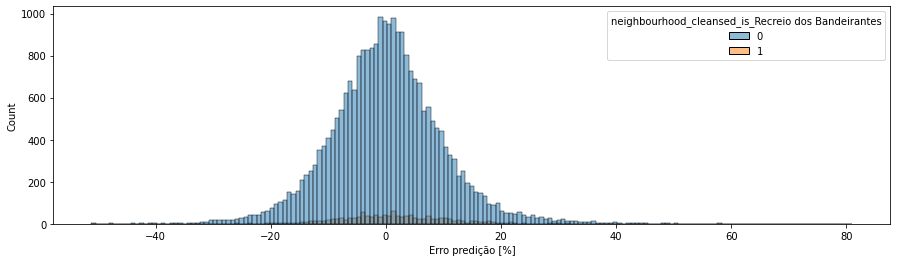

>>>>>>>>>>     neighbourhood_cleansed_is_Leblon


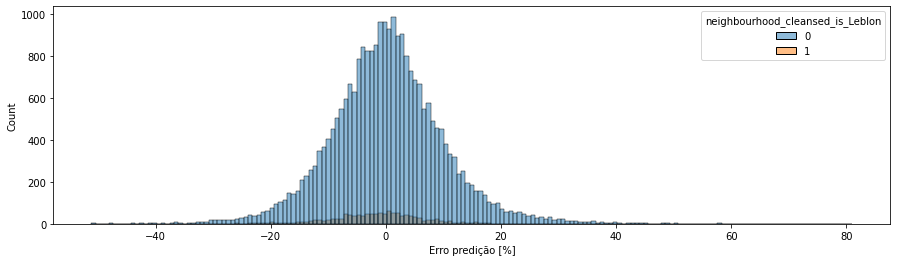

>>>>>>>>>>     neighbourhood_cleansed_is_Santa Teresa


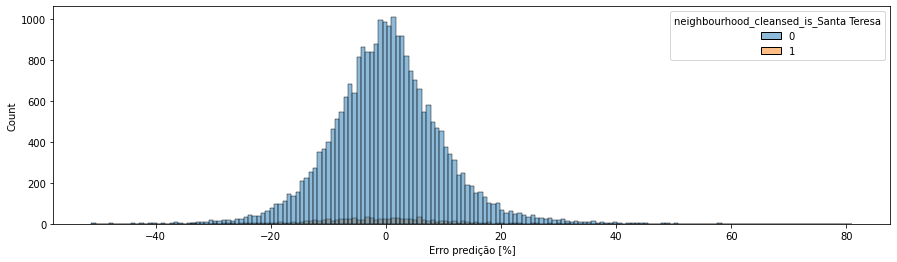

>>>>>>>>>>     neighbourhood_cleansed_is_Centro


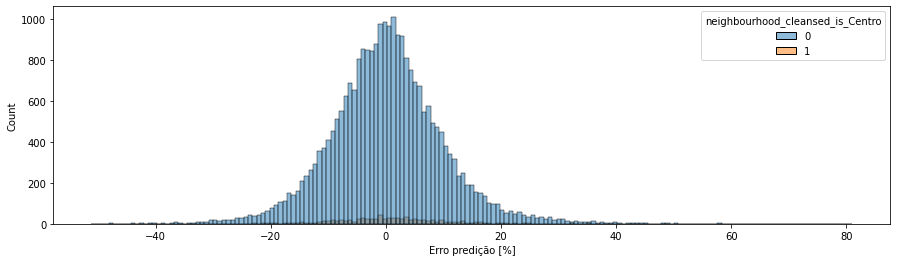

>>>>>>>>>>     neighbourhood_cleansed_is_Flamengo


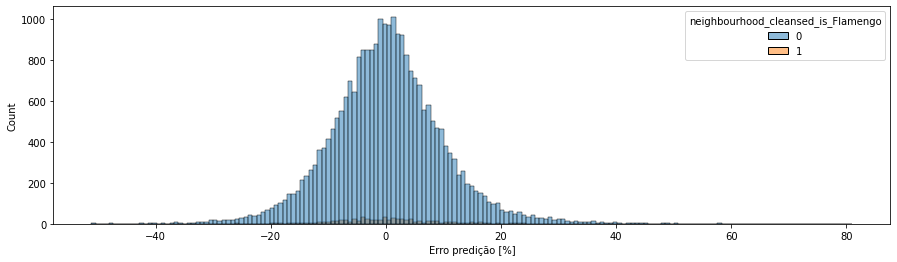

In [262]:
hue_cols = [
       'neighbourhood_cleansed_is_Copacabana',
       'neighbourhood_cleansed_is_Barra da Tijuca',
       'neighbourhood_cleansed_is_Ipanema',
       'neighbourhood_cleansed_is_Jacarepaguá',
       'neighbourhood_cleansed_is_Botafogo',
       'neighbourhood_cleansed_is_Recreio dos Bandeirantes',
       'neighbourhood_cleansed_is_Leblon',
       'neighbourhood_cleansed_is_Santa Teresa',
       'neighbourhood_cleansed_is_Centro',
       'neighbourhood_cleansed_is_Flamengo'
]

for hue in hue_cols:
    print('>'*10, ' '*3, hue)
    ax = sns.histplot(x = 'erro_percentual', hue = hue, data = df)
    ax.set_xlabel('Erro predição [%]')
    plt.show()

Avaliando as features que foram selecionadas

In [263]:
best_features = pd.DataFrame(
        columns = ['ranking'],
        data = best_model.ranking_,
        index = x.columns,
    ).sort_values('ranking', ascending = True)

In [264]:
selected_mask = (best_features['ranking'] == 1)

In [265]:
print(f' {selected_mask.sum()} SELECTED FEATURES')
best_features.loc[selected_mask]

 45 SELECTED FEATURES


,ranking
host_since,1
has_availability_is_t,1
host_response_time_is_NaN,1
host_response_time_is_a few days or more,1
host_is_superhost_is_t,1
neighbourhood_cleansed_is_Copacabana,1
neighbourhood_cleansed_is_Barra da Tijuca,1
neighbourhood_cleansed_is_Ipanema,1
neighbourhood_cleansed_is_Leblon,1
neighbourhood_cleansed_is_Centro,1


In [266]:
print(f' {(~selected_mask).sum()} NOT SELECTED FEATURES')
best_features.loc[~selected_mask]

 12 NOT SELECTED FEATURES


,ranking
neighbourhood_cleansed_is_Santa Teresa,2
neighbourhood_cleansed_is_Flamengo,3
host_location_is_Local,4
amenities_has_pool,5
amenities_has_gym,6
amenities_has_workspace,7
host_has_profile_pic_is_t,8
neighbourhood_cleansed_is_Jacarepaguá,9
neighbourhood_cleansed_is_Recreio dos Bandeirantes,10
neighbourhood_cleansed_is_Botafogo,11
